# Описание проекта

Вы работаете в фотохостинге для профессиональных фотографов «Со Смыслом» (“With Sense”).   

Ваши пользователи размещают свои фотографии на хостинге и сопровождают их полным описанием: указывают место съёмок, модель камеры и т. д. Отличительная особенность сервиса — описание: его может предоставить не только тот, кто размещает фотографию, но и другие пользователи портала. Например, для этой фотографии  
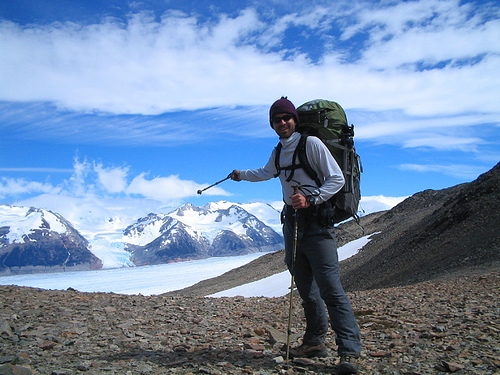  
описание выглядит так:

⎢ A hiker poses for a picture in front of stunning mountains and clouds. 

Ваш отдел занимается экспериментом по разработке поиска референсных фотографий для фотографов. Суть поиска заключается в следующем: пользователь сервиса вводит описание нужной сцены. Например, такое:
⎢ A man is crossing a mountain pass on a metal bridge.
Сервис выводит несколько фотографий с такой же или похожей сценой.  

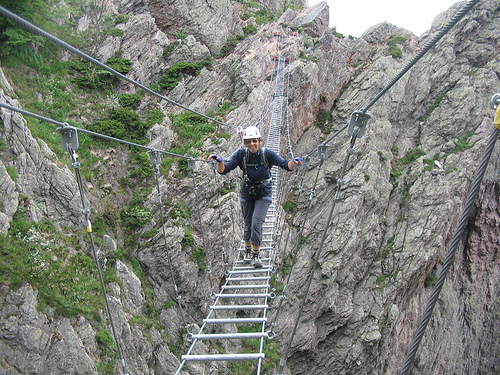  

Чтобы эксперимент получил право на жизнь, нужно защитить его перед руководителем компании. Для защиты необходимо презентовать так называемый PoC (Proof of Concept, Проверка концепции) — продемонстрировать, что такой проект практически осуществим. Вам поручено разработать демонстрационную версию поиска изображений по запросу.  

Для демонстрационной версии нужно выбрать лучшую  модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — и покажет, насколько текст и картинка подходят друг другу. 
На основе лучшей модели можно будет собрать предварительную версию продукта, которую вы покажете руководителю компании.  

# Юридические ограничения

В некоторых странах, где работает компания With Sense, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно, текстов, изображений, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16-ти лет.  
В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:  

⎢ This image is unavailable in your country in compliance with local laws.  

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому необходимо очистить данные от проблемного контента. Во время тестирования модели при появлении в запросе “вредного” контента должен отображаться дисклеймер. 

# Описание данных

В файле train_dataset.csv находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат <имя файла изображения>#<порядковый номер описания>.
В папке train_images содержатся изображения для тренировки модели.  

В файле CrowdAnnotations.tsv  — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:  
1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле ExpertAnnotations.tsv  — данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:
1. Имя файла изображения.
2. Идентификатор описания.  
3. 4, 5 — оценки трёх экспертов. 
Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.      

В файле test_queries.csv находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат <имя файла изображения>#<порядковый номер описания>.

# Первичный анализ

In [268]:
import pandas as pd
import re
import spacy
from PIL import Image
import os
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GroupShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression as lr
from sklearn.metrics import mean_squared_error as mse

from catboost import CatBoostRegressor as cbr

from torchvision import transforms
import torchvision.models as models
import torch.nn as nn
import torch

from PIL import Image

from nltk.corpus import stopwords as nltk_stopwords

In [269]:
RANDOM_STATE = 468513

Загружаем файлы и смотрим на них.

In [270]:
crowd = pd.read_table('./CrowdAnnotations.tsv', names = ['image','query_id', 'correct_proportion', 'correct_number', 'wrong_number'])
expert = pd.read_table('./ExpertAnnotations.tsv', names = ['image','query_id', 'expert_1', 'expert_2', 'expert_3'])
df_test_im = pd.read_csv('./test_images.csv')
df_train = pd.read_csv('./train_dataset.csv')
df_test_qr = pd.read_csv('./test_queries.csv', sep='|')

In [271]:
def get_info(df):
    display(df.info())
    display(df.sample(5))

In [272]:
get_info(crowd)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   image               47830 non-null  object 
 1   query_id            47830 non-null  object 
 2   correct_proportion  47830 non-null  float64
 3   correct_number      47830 non-null  int64  
 4   wrong_number        47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


None

image                     query_id  \
42805   434792818_56375e203f.jpg  3692593096_fbaea67476.jpg#2   
23359  3047264346_e24601bfbf.jpg  3251648670_9339943ba2.jpg#2   
26489   317383917_d8bfa350b6.jpg   384577800_fc325af410.jpg#2   
3862   1626754053_81126b67b6.jpg   249394748_2e4acfbbb5.jpg#2   
34109  3452127051_fa54a902b3.jpg   670609997_5c7fdb3f0b.jpg#2   

       correct_proportion  correct_number  wrong_number  
42805                 0.0               0             3  
23359                 0.0               0             3  
26489                 0.0               0             3  
3862                  0.0               0             3  
34109                 0.0               0             3

In [273]:
get_info(expert)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   expert_1  5822 non-null   int64 
 3   expert_2  5822 non-null   int64 
 4   expert_3  5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


None

image                     query_id  expert_1  \
2309  2854207034_1f00555703.jpg   541063517_35044c554a.jpg#2         1   
4592  3569406219_f37ebf7b92.jpg   421730441_6b2267fd31.jpg#2         1   
795   2105756457_a100d8434e.jpg    53043785_c468d6f931.jpg#2         1   
5196   436009777_440c7679a1.jpg  3354883962_170d19bfe4.jpg#2         1   
533    170100272_d820db2199.jpg  1917265421_aeccf1ca38.jpg#2         1   

      expert_2  expert_3  
2309         2         2  
4592         2         3  
795          1         2  
5196         1         1  
533          1         2

In [274]:
get_info(df_test_im)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 928.0+ bytes


None

image
53  3553476195_fb3747d7c1.jpg
99  2346402952_e47d0065b6.jpg
41   572618443_647483ca82.jpg
81  3514297698_0512623955.jpg
27  3287969199_08e775d896.jpg

In [275]:
get_info(df_test_qr)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  500 non-null    int64 
 1   query_id    500 non-null    object
 2   query_text  500 non-null    object
 3   image       500 non-null    object
dtypes: int64(1), object(3)
memory usage: 15.8+ KB


None

Unnamed: 0                     query_id  \
16           16  1319634306_816f21677f.jpg#1   
10           10   123997871_6a9ca987b1.jpg#0   
369         369  3487131146_9d3aca387a.jpg#4   
431         431   404850242_3a55a4c874.jpg#1   
203         203  3033612929_764d977bd5.jpg#3   

                                            query_text  \
16              A brown dog sits still on a hillside .   
10   Girls wearing sports uniforms and eye protecti...   
369  Six spectators watching a dirt racing car pass...   
431  An Asian woman is taking a photograph outside ...   
203           Two dogs play with each other outdoors .   

                         image  
16   1319634306_816f21677f.jpg  
10    123997871_6a9ca987b1.jpg  
369  3487131146_9d3aca387a.jpg  
431   404850242_3a55a4c874.jpg  
203  3033612929_764d977bd5.jpg

In [276]:
get_info(df_train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


None

image                     query_id  \
1727   136886677_6026c622eb.jpg  3320356356_1497e53f80.jpg#2   
3880  3030566410_393c36a6c5.jpg  2890113532_ab2003d74e.jpg#2   
5810   561417861_8e25d0c0e8.jpg   410453140_5401bf659a.jpg#2   
1162  2599444370_9e40103027.jpg  2599444370_9e40103027.jpg#2   
1348  2892995070_39f3c9a56e.jpg   533483374_86c5d4c13e.jpg#2   

                                             query_text  
1727                A man scales a rock in the forest .  
3880  Two dogs in motion in a grassy field with smal...  
5810  A man stands at the entrance of Yerba Buena Ce...  
1162  Two black dogs are dog paddling in a sparkling...  
1348                               a dog on the beach .

Для понимания как эксперты и краудсорсинг оценивают описание и картинки, объеденим таблицы и посмотрим на распределение оценок.

In [277]:
df = pd.merge(left=df_train,
         right=expert,
         on=['image','query_id'],
         how = "left")
df = pd.merge(left=df,
              right=crowd,
              on=['image','query_id'],
              how='left')

In [278]:
get_info(df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5822 entries, 0 to 5821
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   image               5822 non-null   object 
 1   query_id            5822 non-null   object 
 2   query_text          5822 non-null   object 
 3   expert_1            5822 non-null   int64  
 4   expert_2            5822 non-null   int64  
 5   expert_3            5822 non-null   int64  
 6   correct_proportion  2329 non-null   float64
 7   correct_number      2329 non-null   float64
 8   wrong_number        2329 non-null   float64
dtypes: float64(3), int64(3), object(3)
memory usage: 454.8+ KB


None

image                     query_id  \
4655  2339106348_2df90aa6a9.jpg  2307118114_c258e3a47e.jpg#2   
4709  2815256108_fc1302117d.jpg  3006093003_c211737232.jpg#2   
1410  2894217628_f1a4153dca.jpg  2933637854_984614e18b.jpg#2   
1576  2774430374_fee1d793e7.jpg  3472364264_dbde5a8d0a.jpg#2   
4054  3138399980_d6ab8b2272.jpg  2759860913_f75b39d783.jpg#2   

                                             query_text  expert_1  expert_2  \
4655  A man wearing a black shirt and baseball cap s...         1         1   
4709  The man in glasses carrying an Obama poster is...         2         2   
1410  A man in an orange jersey with the letter " 12...         3         3   
1576  a large dog runs on the beach with something h...         1         1   
4054                    A man on top of a high mountain         1         1   

      expert_3  correct_proportion  correct_number  wrong_number  
4655         2                 NaN             NaN           NaN  
4709         3                 0.0             0.0           3.0  
1410         3                 1.0             3.0           0.0  
1576         1                 0.0             0.0           3.0  
4054         2                 0.0             0.0           3.0

Теперь будем смотреть как сильно расходятся оценки.

Для удобства остваим строки где количество краудсорсинг ответов было 3 

In [279]:
score_correlation = df.loc[df['wrong_number']+df['correct_number'] == 3]

In [280]:
get_info(score_correlation)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2266 entries, 0 to 5820
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   image               2266 non-null   object 
 1   query_id            2266 non-null   object 
 2   query_text          2266 non-null   object 
 3   expert_1            2266 non-null   int64  
 4   expert_2            2266 non-null   int64  
 5   expert_3            2266 non-null   int64  
 6   correct_proportion  2266 non-null   float64
 7   correct_number      2266 non-null   float64
 8   wrong_number        2266 non-null   float64
dtypes: float64(3), int64(3), object(3)
memory usage: 177.0+ KB


None

image                     query_id  \
1630   541063517_35044c554a.jpg   302983277_69a4e732e4.jpg#2   
2581  3609032038_005c789f64.jpg   150387174_24825cf871.jpg#2   
3605  2078311270_f01c9eaf4c.jpg  3498997518_c2b16f0a0e.jpg#2   
510   3334537556_a2cf4e9b9a.jpg  2100816230_ff866fb352.jpg#2   
3948  2160266952_a2ab39191b.jpg   170100272_d820db2199.jpg#2   

                                             query_text  expert_1  expert_2  \
1630  A man riding a brown horse poses in front of a...         2         2   
2581      A man is riding a dirt bike over some rocks .         4         4   
3605  A football player is tackling the player with ...         1         1   
510                     A man jumps while snow skiing .         2         2   
3948  A girl goes down a blue and yellow slide at a ...         1         2   

      expert_3  correct_proportion  correct_number  wrong_number  
1630         3                 0.0             0.0           3.0  
2581         4                 1.0             3.0           0.0  
3605         1                 0.0             0.0           3.0  
510          2                 0.0             0.0           3.0  
3948         2                 0.0             0.0           3.0

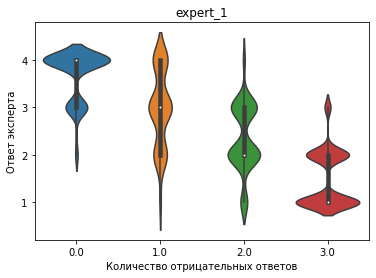

In [281]:
voi1 = sns.violinplot(x= score_correlation['wrong_number'], y= score_correlation['expert_1'])
voi1.axes.set_title('expert_1')
voi1.set_ylabel('Ответ эксперта')
voi1.set_xlabel('Количество отрицательных ответов');

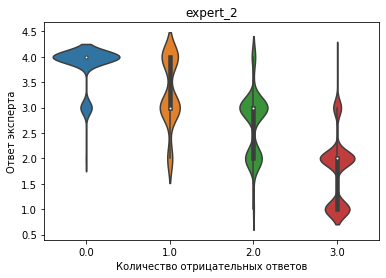

In [282]:
voi2 = sns.violinplot(x= score_correlation['wrong_number'], y= score_correlation['expert_2'])
voi2.axes.set_title('expert_2')
voi2.set_ylabel('Ответ эксперта')
voi2.set_xlabel('Количество отрицательных ответов');

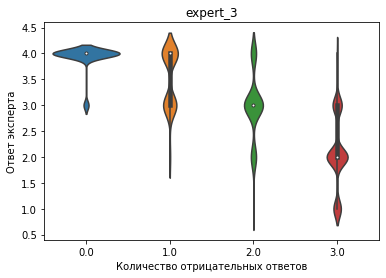

In [283]:
voi3 = sns.violinplot(x= score_correlation['wrong_number'], y= score_correlation['expert_3'])
voi3.axes.set_title('expert_3')
voi3.set_ylabel('Ответ эксперта')
voi3.set_xlabel('Количество отрицательных ответов');

Как видно мнение экспертов и краудсорсинга похожи, просто у экспертов было больше простарнства для "маневра", но видно что чем хуже описание тем больше человек с ним не соглашалось. По этому возьмем мнение экспертов за основу и к нему добавим  краудсорсинг будем с этим работать. Но для начала нужно добавить целевой столбец.

In [284]:
get_info(df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5822 entries, 0 to 5821
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   image               5822 non-null   object 
 1   query_id            5822 non-null   object 
 2   query_text          5822 non-null   object 
 3   expert_1            5822 non-null   int64  
 4   expert_2            5822 non-null   int64  
 5   expert_3            5822 non-null   int64  
 6   correct_proportion  2329 non-null   float64
 7   correct_number      2329 non-null   float64
 8   wrong_number        2329 non-null   float64
dtypes: float64(3), int64(3), object(3)
memory usage: 454.8+ KB


None

image                     query_id  \
4639  2333288869_8c01e4c859.jpg  2061354254_faa5bd294b.jpg#2   
4893  3458559770_12cf9f134e.jpg  3316725440_9ccd9b5417.jpg#2   
1398   539751252_2bd88c456b.jpg  3564543247_05cdbc31cf.jpg#2   
4631  2317714088_bcd081f926.jpg  3310067561_b92017acab.jpg#2   
2615   820169182_f5e78d7d19.jpg  3222055946_45f7293bb2.jpg#2   

                                       query_text  expert_1  expert_2  \
4639  A little boy is going down a pulley swing .         1         1   
4893        A man rides a bike through a course .         4         4   
1398               Two guys jumping into a pool .         2         3   
4631    A dog lies down on a cobblestone street .         1         1   
2615               Basketball players in action .         1         1   

      expert_3  correct_proportion  correct_number  wrong_number  
4639         1                 NaN             NaN           NaN  
4893         4                 1.0             3.0           0.0  
1398         3                 0.0             0.0           3.0  
4631         1                 NaN             NaN           NaN  
2615         1                 NaN             NaN           NaN

Отлично, теперь можно заняться обработкой текста.

По скольку на выходе нам нужно получить вероятность соответствия картики и текста, то и целевая переменная должна показывать вероятность.

По этому будем брать оценки экспертов и краудсорсинга в пропорции 0.7 и 0.3. Что-бы перевести оценку экспертов в вероятность, нужно придумать какуюто градацию их оценок, самое простое что приходит на ум это:  
1 - 0  
2 - 0.33  
3 - 0.66  
4 - 1  
В краудсорсинге будем просто брать долю людей говорящих что это правильное описание.
Так же нужно учитывать, есть ли данные по краудсорсингу в принципе, если их нету, то максимум который можем получить это 0.7, что не будет отражать действительность.

Но сначала ужно заполнить нулями отсутствующие значения.

In [285]:
df['correct_number'].isna()

0       False
1        True
2       False
3       False
4        True
        ...  
5817    False
5818     True
5819     True
5820    False
5821     True
Name: correct_number, Length: 5822, dtype: bool

In [286]:
df['correct_proportion'] = df['correct_proportion'].fillna(0)
df['support'] = 0
df.loc[df['correct_number'].isna(), 'support'] = 1

In [287]:
df['target'] = (df['expert_1'] + df['expert_2'] + df['expert_3'] - 3)*0.33*(0.7+0.3*df['support'])/3 + df['correct_proportion']*0.3
get_info(df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5822 entries, 0 to 5821
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   image               5822 non-null   object 
 1   query_id            5822 non-null   object 
 2   query_text          5822 non-null   object 
 3   expert_1            5822 non-null   int64  
 4   expert_2            5822 non-null   int64  
 5   expert_3            5822 non-null   int64  
 6   correct_proportion  5822 non-null   float64
 7   correct_number      2329 non-null   float64
 8   wrong_number        2329 non-null   float64
 9   support             5822 non-null   int64  
 10  target              5822 non-null   float64
dtypes: float64(4), int64(4), object(3)
memory usage: 545.8+ KB


None

image                     query_id  \
468   1808370027_2088394eb4.jpg   541063517_35044c554a.jpg#2   
734   3484832904_08619300d9.jpg  3470951932_27ed74eb0b.jpg#2   
1115  3585598356_8ce815bbb9.jpg  3727752439_907795603b.jpg#2   
949   2479162876_a5ce3306af.jpg  3593392955_a4125087f6.jpg#2   
2428  1467533293_a2656cc000.jpg  3245912109_fdeef6b456.jpg#2   

                                             query_text  expert_1  expert_2  \
468   A man in grey on a rocky cliff , overlooking t...         1         1   
734                     A boy runs to a baseball base .         1         2   
1115  a woman wearing a black and white outfit while...         2         2   
949       Two dogs run down a dirt path in the forest .         2         2   
2428  Many bundled up people are standing in a publi...         1         1   

      expert_3  correct_proportion  correct_number  wrong_number  support  \
468          1                 0.0             NaN           NaN        1   
734          2                 0.0             0.0           3.0        0   
1115         2                 0.0             0.0           3.0        0   
949          2                 0.0             0.0           3.0        0   
2428         1                 0.0             NaN           NaN        1   

      target  
468    0.000  
734    0.154  
1115   0.231  
949    0.231  
2428   0.000

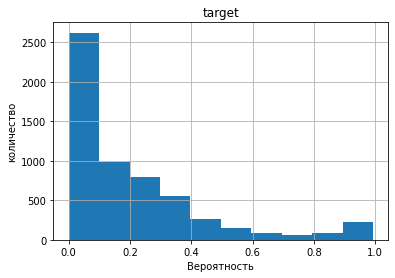

In [288]:
plt.xlabel("Вероятность")
plt.ylabel("количество")
plt.title("target")
df['target'].hist()
plt.show()

Как видно, получилось сделать не плохое распределение по оценкам, очень похожее на настоящее. 

Теперь можно удалть лишние столбцы и заняться обработкой текста и фотографий.

In [289]:
df = df.drop(['expert_1', 
              'expert_2', 
              'expert_3', 
              'correct_proportion', 
              'correct_number', 
              'wrong_number',
              'query_id',
              'support'], 
              axis=1).reset_index(drop=True)

In [290]:
get_info(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       5822 non-null   object 
 1   query_text  5822 non-null   object 
 2   target      5822 non-null   float64
dtypes: float64(1), object(2)
memory usage: 136.6+ KB


None

image  \
3113  3228069008_edb2961fc4.jpg   
774    300550441_f44ec3701a.jpg   
849    215214751_e913b6ff09.jpg   
5807   497791037_93499238d8.jpg   
3126  2274992140_bb9e868bb8.jpg   

                                             query_text  target  
3113                    Two dogs playing on the beach .    0.33  
774   A golden retriever running on short grass wear...    0.00  
849   An older couple posing in front of a fountain ...    0.00  
5807  An actor dressed as a pirate performs in an ou...    0.22  
3126  A smiling woman embracing a young girl in a ja...    0.00

# Обркаботка текста.

В первую очередь нужно создать список слов которые нам не подходят по законам страны.

In [291]:
forbidden_words = ['babe',
                    'young boy',
                    'youngster',
                    'toddler',
                    'little child',
                    'little baby'
                    'little boy',
                    'tot',
                    'kiddy',
                    'offspring',
                    'kids',
                    'orphanage',
                    'infancy',
                    'infantile',
                    'son',
                    'little thing',
                    'calf',
                    'pup',
                    'crumb',
                    'creation',
                    'nurse',
                    'child',
                    'infant',
                    'teenager',
                    'adolescent',
                    'teens',
                    'teen',
                    'youngster',
                    'adolescence',
                    'juvenile',
                    'youth',
                    'little girl',
                    'baby girl',
                    'young girl']

Теперь можно привести текст к лемам и почистить его, за одно проверим запросы на законность.

In [292]:
nlp = spacy.load("en_core_web_sm")
def lemmatize(df):
    text = ''
    df['query_text'] = df['query_text'].lower()
    doc = nlp(df['query_text'])
    for token in doc:
        if token.is_stop: continue
        text += f'{token.lemma_} '
    flag = 1
    for word in forbidden_words:
        if word in text:
            df['query_text'] = "This image is unavailable in your country in compliance with local laws"
            flag = 0
            break
    if flag: 
        df['query_text'] = text
        df['query_text'] = re.sub(r'[.,()!?:;\-\'\"=\[\]&/\\]','',df['query_text'])
        df['query_text'] = re.sub(r'\s',' ',df['query_text'])
    return df

In [293]:
cl_df = df.apply(lemmatize,axis=1)

In [294]:
get_info(cl_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       5822 non-null   object 
 1   query_text  5822 non-null   object 
 2   target      5822 non-null   float64
dtypes: float64(1), object(2)
memory usage: 136.6+ KB


None

image  \
2527  3325497914_f9014d615b.jpg   
3502  3138399980_d6ab8b2272.jpg   
4351  2884301336_dc8e974431.jpg   
1560   317109978_cb557802e1.jpg   
4434  2612488996_9450de0e54.jpg   

                                             query_text  target  
2527                          people sit outdoor cafe     0.110  
3502                                  kid swinge swing    0.000  
4351  This image is unavailable in your country in c...   0.000  
1560                   brown dog hop fall tree branch     0.993  
4434                       woman right wear red scarf     0.000

Интересно сколько запросов попало под ограничение.

In [295]:
len(cl_df.loc[cl_df['query_text'] == "This image is unavailable in your country in compliance with local laws"])

1065

Почти тысяча запросов, прилично. 

Так же можно посмотреть на парочку запросов которые были отсеяны.

In [296]:
df.loc[cl_df['query_text'] == "This image is unavailable in your country in compliance with local laws", 'query_text'].sample(10)

3443    A person in a green jacket it surfing while ho...
1976    People at park sitting on benches and a woman ...
3266    A person in a red shirt climbing up a rock fac...
453     A person is in the air while riding his bicycl...
4955    A small child sucks his thumb while sleeping w...
1444    A group of children gather around a white dog ...
3260          A child swinging on a playground play set .
4280     A little girl is sliding down a tunnel smiling .
2760    A young girl is wearing a purple shirt and pin...
5189    A woman is holding up a child as they coming s...
Name: query_text, dtype: object

На первый взгляд функция работат правильно.

Для дальнейшей работы нужно поделить выборки.

In [297]:
сl_df = cl_df.loc[cl_df['query_text'] != "This image is unavailable in your country in compliance with local laws"].reset_index(drop=True)

In [298]:
get_info(сl_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4757 entries, 0 to 4756
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       4757 non-null   object 
 1   query_text  4757 non-null   object 
 2   target      4757 non-null   float64
dtypes: float64(1), object(2)
memory usage: 111.6+ KB


None

image  \
1947   430173345_86388d8822.jpg   
3516  3468694409_a51571d621.jpg   
1931  3470951932_27ed74eb0b.jpg   
2804   524282699_71e678a6bd.jpg   
3897  2396691909_6b8c2f7c44.jpg   

                                             query_text  target  
1947  white dog run gravel away people black brown d...   0.154  
3516  young woman sit ledge black purse look finger ...   0.110  
1931          man rugby uniform hit ball grassy field     0.077  
2804           black dog come ocean water beach mouth     0.308  
3897                                somebody air board    0.110

In [299]:
gss = GroupShuffleSplit(n_splits=1, train_size=.8, random_state=RANDOM_STATE)
train_indices, test_indices = next(gss.split(X=сl_df.drop(columns=['target']), y=сl_df['target'], groups=сl_df['image']))
train, test = сl_df.loc[train_indices], сl_df.loc[test_indices]
train = train.reset_index(drop=True)

In [300]:
get_info(train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3808 entries, 0 to 3807
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       3808 non-null   object 
 1   query_text  3808 non-null   object 
 2   target      3808 non-null   float64
dtypes: float64(1), object(2)
memory usage: 89.4+ KB


None

image                                 query_text  \
1657  2878272032_fda05ffac7.jpg           grey dog swim river stick mouth    
636   2228022180_9597b2a458.jpg          group adult stand pose building     
2387  2308271254_27fb466eb4.jpg                    man hold fishing pole     
1916   317383917_d8bfa350b6.jpg  dog  brown white black white  run field     
579   1897025969_0c41688fa6.jpg   furry dog attempt dry shake water coat     

      target  
1657   0.330  
636    0.231  
2387   0.000  
1916   0.231  
579    0.220

In [301]:
get_info(test)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 949 entries, 0 to 4752
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       949 non-null    object 
 1   query_text  949 non-null    object 
 2   target      949 non-null    float64
dtypes: float64(1), object(2)
memory usage: 29.7+ KB


None

image  \
3048   241345905_5826a72da1.jpg   
3427  2999730677_0cfa1c146e.jpg   
34     132489044_3be606baf7.jpg   
3146  3154641421_d1b9b8c24c.jpg   
3180  3694064560_467683205b.jpg   

                                           query_text  target  
3048             little boy helmet trick skateboard     0.110  
3427                     dog move water close shore     0.330  
34    man woman look camera stand red art structure     0.077  
3146                                  dog wade water    0.000  
3180                      group performer dance djs     0.220

In [302]:
gss = GroupShuffleSplit(n_splits=1, train_size=.75, random_state=RANDOM_STATE)
train_indices, vall_indices = next(gss.split(X=train.drop(columns=['target']), y=train['target'], groups=train['image']))
train, vall = train.loc[train_indices], train.loc[vall_indices]

In [303]:
get_info(vall)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 958 entries, 3 to 3800
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       958 non-null    object 
 1   query_text  958 non-null    object 
 2   target      958 non-null    float64
dtypes: float64(1), object(2)
memory usage: 29.9+ KB


None

image  \
344   1982852140_56425fa7a2.jpg   
363    241346971_c100650320.jpg   
930   3457045393_2bbbb4e941.jpg   
806   3255482333_5bcee79f7e.jpg   
1495  3569979711_6507841268.jpg   

                                             query_text  target  
344                               dog run beach ocean     0.231  
363        group people walk city street warm weather     0.000  
930   middle aged man stand white wall underneath ca...   0.000  
806                        skier throw snow ski piste     0.993  
1495        young  long  haired  girl beach  jump air     0.385

In [304]:
train['query_text'].values

array(['girl wear yellow shirt sunglass smile  ',
       'girl wear yellow shirt sunglass smile  ',
       'girl wear yellow shirt sunglass smile  ', ...,
       'dog stand grassy cliff  ', 'blurry photo dog  ', 'man row boat  '],
      dtype=object)

In [305]:
corpus = train['query_text'].values
stopwords = list(nltk_stopwords.words('english'))
tf_idf = TfidfVectorizer(stop_words=stopwords).fit(corpus)
train_tf = tf_idf.transform(corpus)

corpus = test['query_text'].values
test_tf = tf_idf.transform(corpus)

corpus = vall['query_text'].values
vall_tf = tf_idf.transform(corpus)

In [306]:
train_tf

<2850x961 sparse matrix of type '<class 'numpy.float64'>'
	with 15359 stored elements in Compressed Sparse Row format>

In [307]:
test_tf

<949x961 sparse matrix of type '<class 'numpy.float64'>'
	with 5144 stored elements in Compressed Sparse Row format>

In [308]:
vall_tf

<958x961 sparse matrix of type '<class 'numpy.float64'>'
	with 5203 stored elements in Compressed Sparse Row format>

In [309]:
vall_tf.toarray()

array([[0.        , 0.        , 0.        , ..., 0.45400715, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [310]:
vall_tf

<958x961 sparse matrix of type '<class 'numpy.float64'>'
	with 5203 stored elements in Compressed Sparse Row format>

Отлично, тексты готовы, теперь изображения.

# Обработка изображений

Для перевода изображения в тензоры будем использовать ResNet.

Напишем функцию для обработки

In [340]:
def get_emb (df, way='train'):
    norm = transforms.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        norm,
    ]) 

    resnet = models.resnet18(pretrained=True)
    for param in resnet.parameters():
        param.requires_grad_(False) 
    modules = list(resnet.children())[:-2]
    resnet = nn.Sequential(*modules) 
    resnet.eval() 

    img = Image.open(f"D:/Practicum/Final_project_4/{way}_images/{df.loc[0,'image']}").convert('RGB')
    image_tensor = preprocess(img)
    
    tenzor = resnet(image_tensor.unsqueeze(0)).flatten()
    l = len(tenzor)
    tenzor = tenzor.reshape(1,l)
    c = 0
    for i in df.loc[1:,'image']:
        c += 1
        img = Image.open(f"D:/Practicum/Final_project_4/{way}_images/{i}").convert('RGB')
        image_tensor = preprocess(img)

        tenzor = torch.cat([tenzor, resnet(image_tensor.unsqueeze(0)).flatten().reshape(1,l)])

    return tenzor


Теперь можно перевести изображения.

In [341]:
train_tnz = get_emb(train)

d:\Python\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Python\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [313]:
train_tnz.shape

torch.Size([2850, 25088])

Есть изображения теперь бъедениям их с описанием

In [314]:
train_features = np.hstack((train_tnz,train_tf.toarray()))

In [315]:
train_features.shape

(2850, 26049)

In [316]:
vall = vall.reset_index()

In [342]:
vall_tnz = get_emb(vall)

In [318]:
vall_features = np.hstack((vall_tnz,vall_tf.toarray()))
vall_features.shape

(958, 26049)

In [343]:
test = test.reset_index()
test_tnz = get_emb(test)
test_features = np.hstack((test_tnz,test_tf.toarray()))
test_features.shape

d:\Python\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Python\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


(949, 26049)

In [320]:
train_ans = train['target'].values
vall_ans = vall['target'].values
test_ans = test['target'].values

Все подготовлено к обучению.

# Обучение моделей

## LinearRegression

Начнем с самого простого LinearRegression

In [321]:
model_lr = lr()
model_lr.fit(train_features, train_ans)

LinearRegression()

In [322]:
mse(vall_ans, model_lr.predict(vall_features), squared = False)

2797516670057.361

Как видно, LinearRegression вообще не может найти закономерности

## CatBoostRegressor

Теперь можно рассмотреть другую модел, CatBoostRegressor

In [331]:
model_cbr = cbr(random_seed = RANDOM_STATE,
                logging_level='Silent')
model_cbr.fit(train_features, train_ans)

In [332]:
mse(vall_ans, model_cbr.predict(vall_features), squared = False)

0.21668039051984841

Уже лучше, катбуст уже что-то может.

In [333]:
send(f'{mse(vall_ans, model_cbr.predict(vall_features), squared = False)}')

In [329]:
parametrs = {'depth' :[6],
            'iterations' : [1000],
            'learning_rate' : [.7,.8],
            'l2_leaf_reg':[.1,.3]}
model_cbr = GridSearchCV(cbr(random_seed= RANDOM_STATE,
                        logging_level='Silent'), 
                    parametrs, 
                    scoring = 'neg_root_mean_squared_error',
                    verbose = 3,
                    cv=3)
model_cbr.fit(train_features, train_ans)
print (model_cbr.best_params_)
print (model_cbr.best_score_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3] END depth=6, iterations=1000, l2_leaf_reg=0.1, learning_rate=0.7;, score=-0.295 total time=45.8min
[CV 2/3] END depth=6, iterations=1000, l2_leaf_reg=0.1, learning_rate=0.7;, score=-0.273 total time=44.5min
[CV 3/3] END depth=6, iterations=1000, l2_leaf_reg=0.1, learning_rate=0.7;, score=-0.277 total time=45.5min
[CV 1/3] END depth=6, iterations=1000, l2_leaf_reg=0.1, learning_rate=0.8;, score=-0.302 total time=42.8min
[CV 2/3] END depth=6, iterations=1000, l2_leaf_reg=0.1, learning_rate=0.8;, score=-0.279 total time=45.4min
[CV 3/3] END depth=6, iterations=1000, l2_leaf_reg=0.1, learning_rate=0.8;, score=-0.296 total time=45.5min
[CV 1/3] END depth=6, iterations=1000, l2_leaf_reg=0.3, learning_rate=0.7;, score=-0.294 total time=45.5min
[CV 2/3] END depth=6, iterations=1000, l2_leaf_reg=0.3, learning_rate=0.7;, score=-0.276 total time=45.6min
[CV 3/3] END depth=6, iterations=1000, l2_leaf_reg=0.3, learning_rate=0.7;, 

NameError: name 'cbc' is not defined

In [330]:
mse(vall_ans, model_cbr.predict(vall_features), squared = False)

0.27078013761595804

Как это не странно но после подбора гиперпарметров катбуст стал хужее, по этому оставим значения по умолчанию.

## Net

Теперь можно и создать нейроную сеть, но сначала переведем все в тензоры.

In [79]:
train_features = torch.FloatTensor(train_features)
vall_features = torch.FloatTensor(vall_features)
train_ans = torch.FloatTensor(train_ans)
vall_ans = torch.FloatTensor(vall_ans)
test_features = torch.FloatTensor(test_features)
test_ans = torch.FloatTensor(test_ans)

Попробуем случайную неронку.

In [238]:
n_neurons = [train_features.shape[1], 120, 1]
net_layers1 = []

for i in range(1, len(n_neurons) - 1):
		net_layers1.append(nn.Linear(n_neurons[i-1],n_neurons[i])) 
		if (i+1) % 2 == 0:
				net_layers1.append(nn.Tanh()) 
net_layers1.append(nn.Linear(n_neurons[-2], n_neurons[-1]))
net1 = nn.Sequential(*net_layers1)


L1_train = []
L1_test = []


optimizer = torch.optim.Adam(net1.parameters(),lr=1e-3)

loss = nn.MSELoss()

num_epochs = 1000
for epoch in range(num_epochs):
    net1.train()
    optimizer.zero_grad()
    
    preds = net1.forward(train_features).flatten()
    loss_value = torch.sqrt(loss(preds, train_ans))
    loss_value.backward()
    
    optimizer.step()
    
    if epoch % 10 == 0 or epoch == num_epochs-1:
        print(epoch)
        L1_train.append(loss_value.detach().numpy())
        net1.eval()
        vall_pred = net1.forward(vall_features).flatten()
        L1 = torch.sqrt(loss(vall_pred,vall_ans))
        L1_test.append(L1.detach().numpy())

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
999


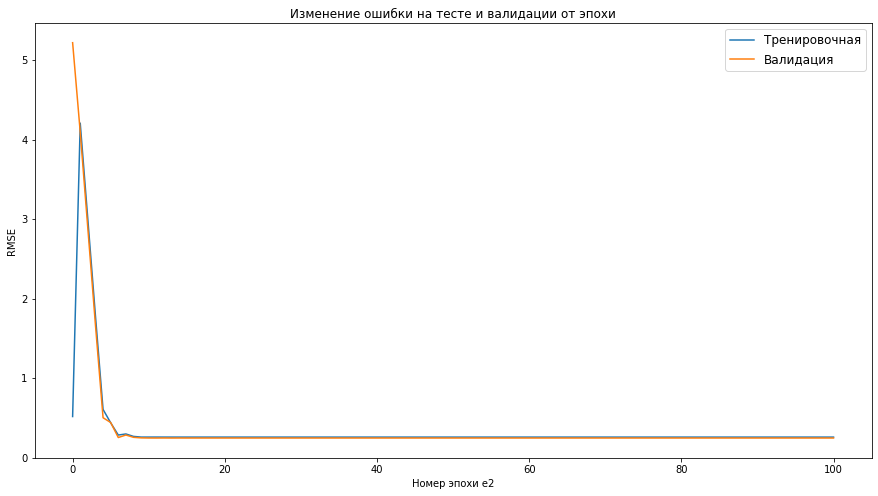

In [86]:
x = np.array(range(0, len(L1_test)))
plt.figure(figsize=(15,8))
plt.title('Изменение ошибки на тесте и валидации от эпохи')
plt.xlabel('Номер эпохи е2')
plt.ylabel('RMSE')
plt.plot(x,L1_train,label='Тренировочная')
plt.plot(x,L1_test,label='Валидация')
plt.legend(loc='best', fontsize=12)
plt.show()

In [92]:
mse(vall_ans.detach(), net1.forward(vall_features).flatten().detach(), squared = False)

0.24539706

Результат хуже чем у катбуста, поробюуем поэксперементировать с настройками.

Номер сети: 0
Номер сети: 1
Номер сети: 2
Номер сети: 3
Номер сети: 4
Номер сети: 5
Номер сети: 6
Номер сети: 7
Номер сети: 8
Номер сети: 9


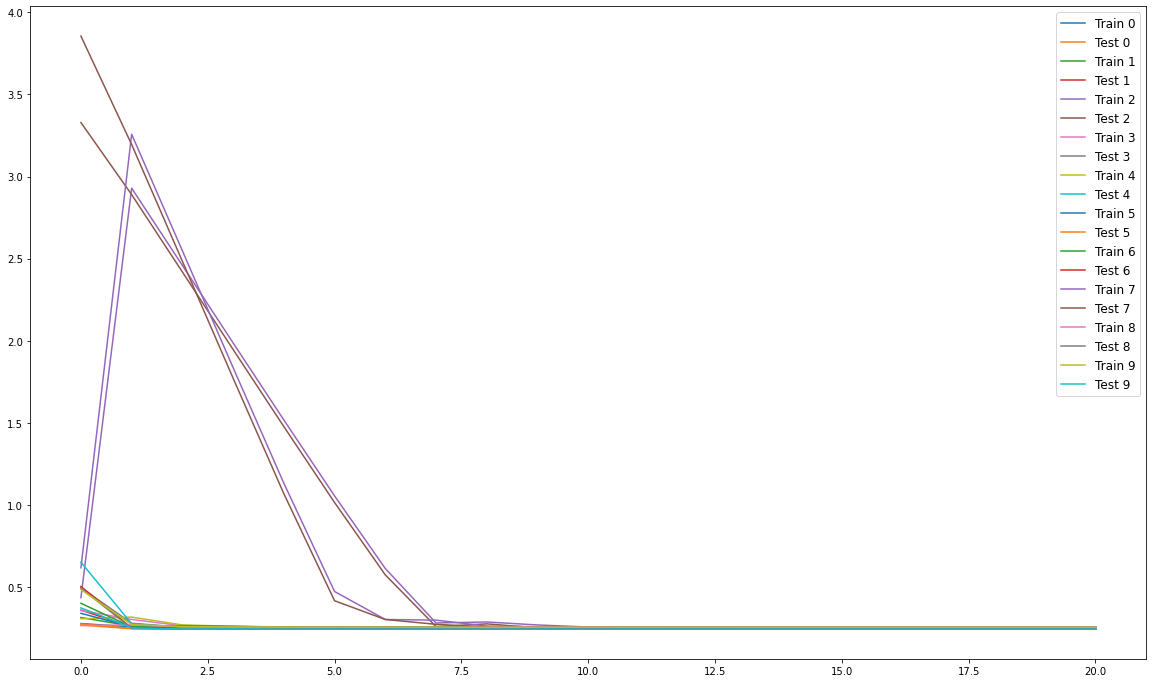

Номер сети: 10
Номер сети: 11
Номер сети: 12
Номер сети: 13
Номер сети: 14
Номер сети: 15
Номер сети: 16
Номер сети: 17
Номер сети: 18
Номер сети: 19


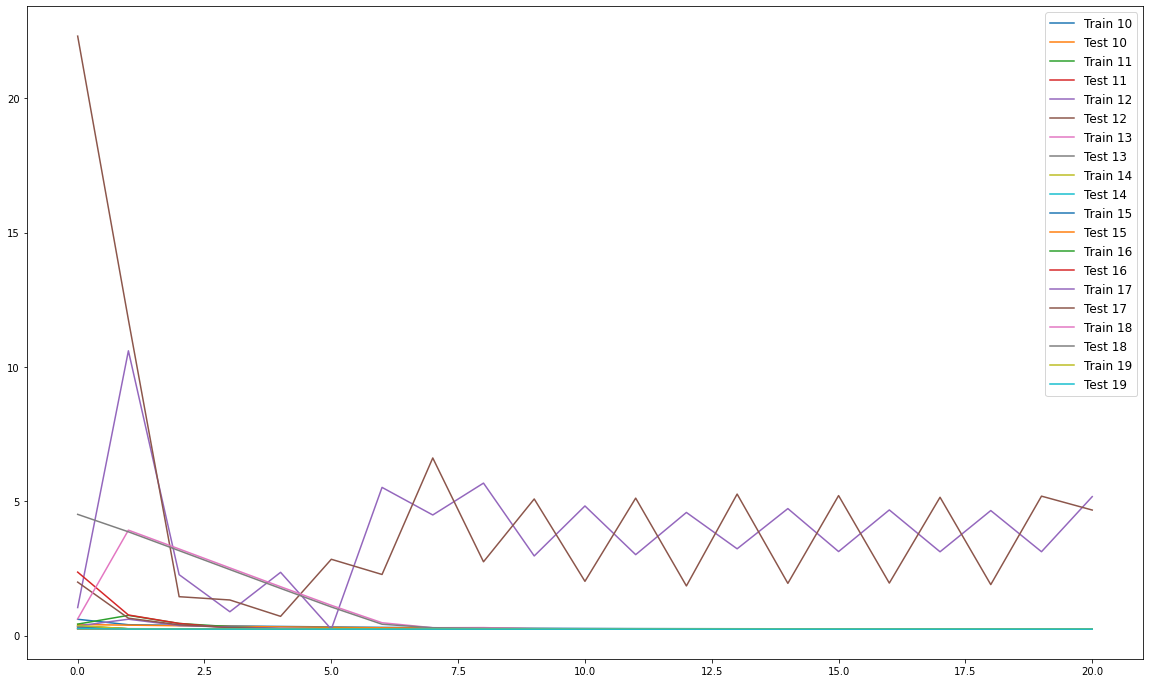

Номер сети: 20
Номер сети: 21
Номер сети: 22
Номер сети: 23
Номер сети: 24
Номер сети: 25
Номер сети: 26
Номер сети: 27
Номер сети: 28
Номер сети: 29


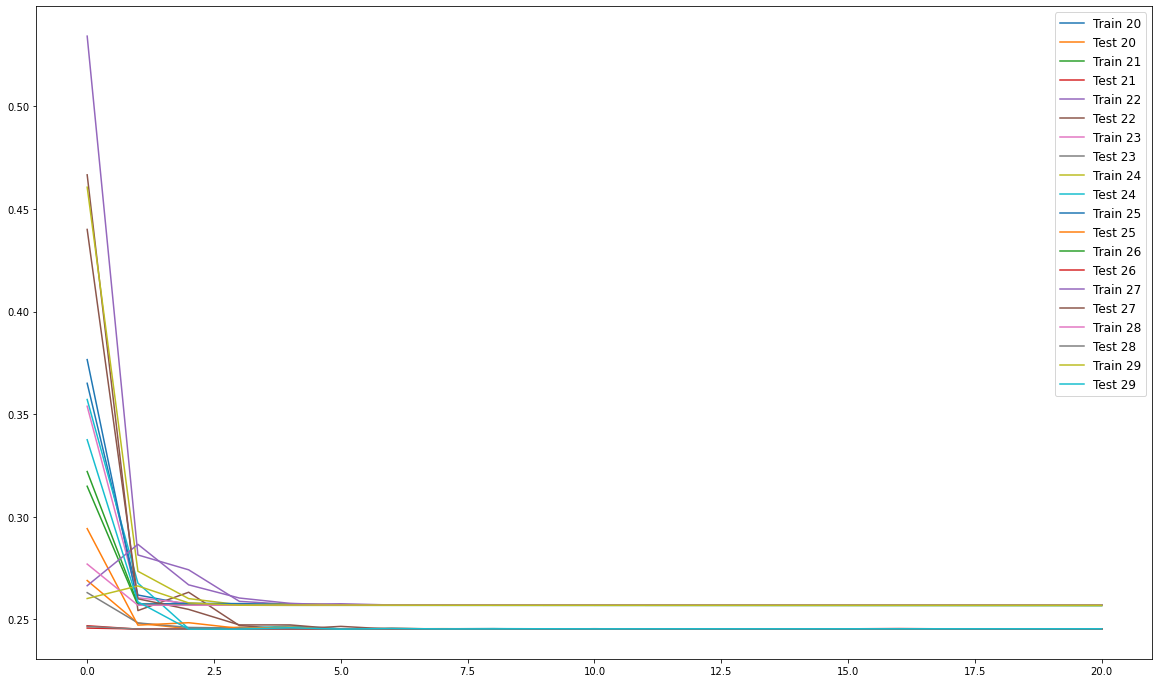

Номер сети: 30
Номер сети: 31
Номер сети: 32
Номер сети: 33
Номер сети: 34
Номер сети: 35
Номер сети: 36
Номер сети: 37
Номер сети: 38
Номер сети: 39


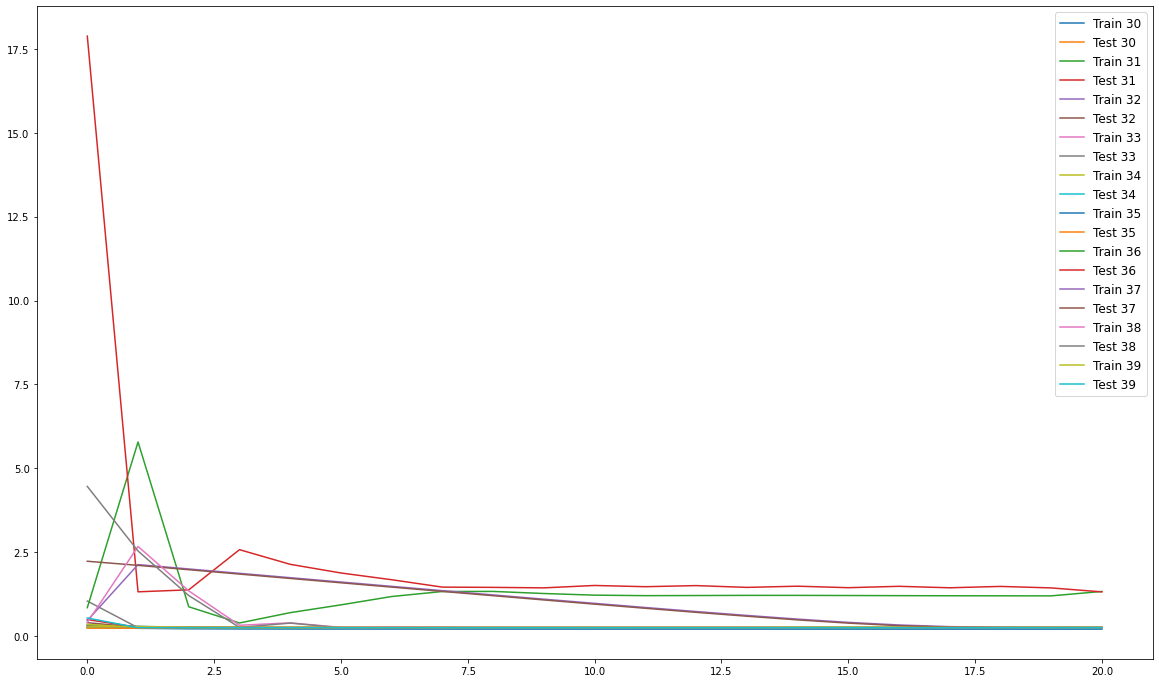

Номер сети: 40
Номер сети: 41
Номер сети: 42
Номер сети: 43
Номер сети: 44
Номер сети: 45
Номер сети: 46
Номер сети: 47
Номер сети: 48
Номер сети: 49


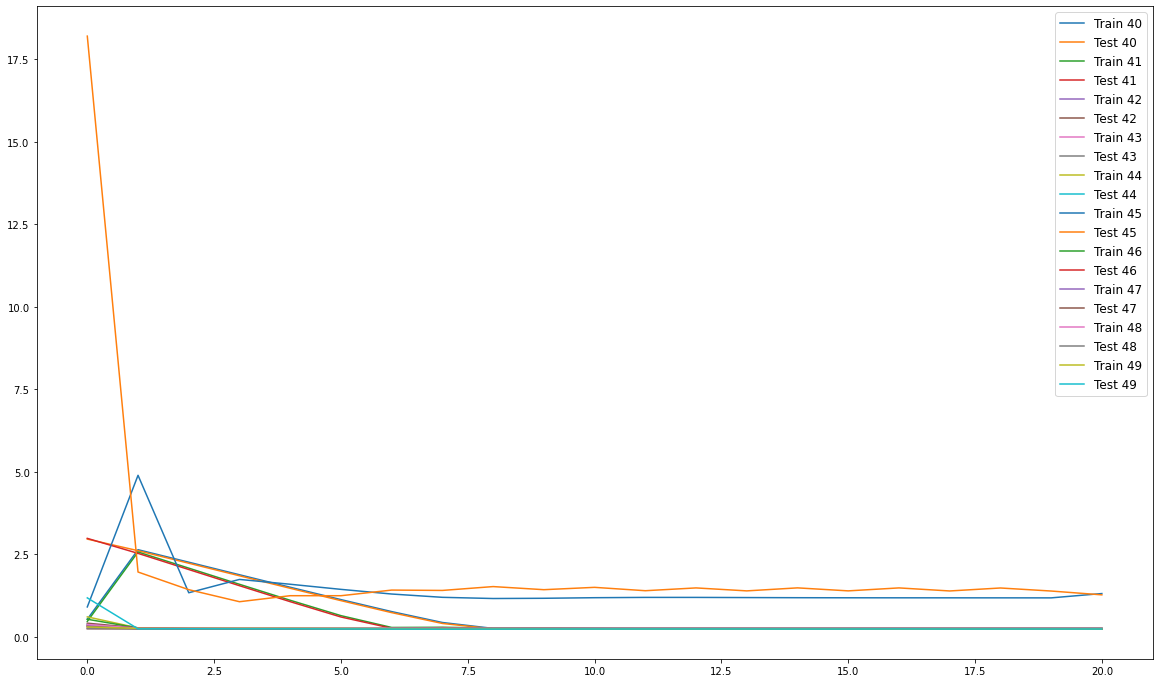

Номер сети: 50
Номер сети: 51
Номер сети: 52
Номер сети: 53
Номер сети: 54
Номер сети: 55
Номер сети: 56
Номер сети: 57
Номер сети: 58
Номер сети: 59


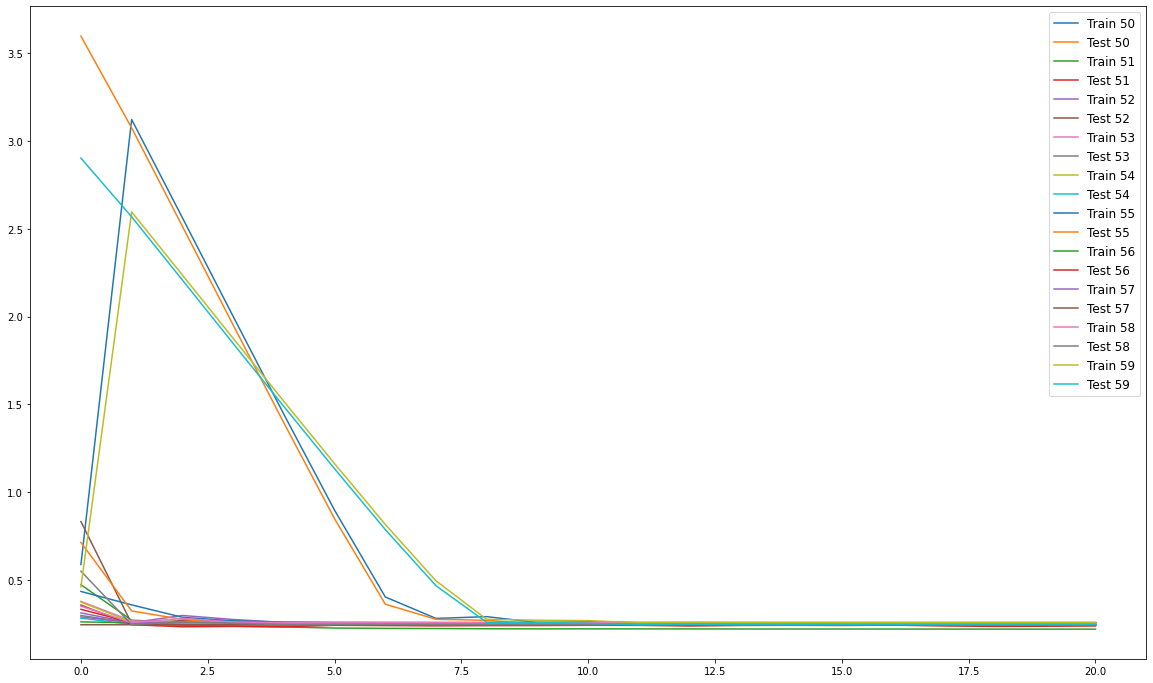

Номер сети: 60
Номер сети: 61
Номер сети: 62
Номер сети: 63
Номер сети: 64
Номер сети: 65
Номер сети: 66
Номер сети: 67
Номер сети: 68
Номер сети: 69


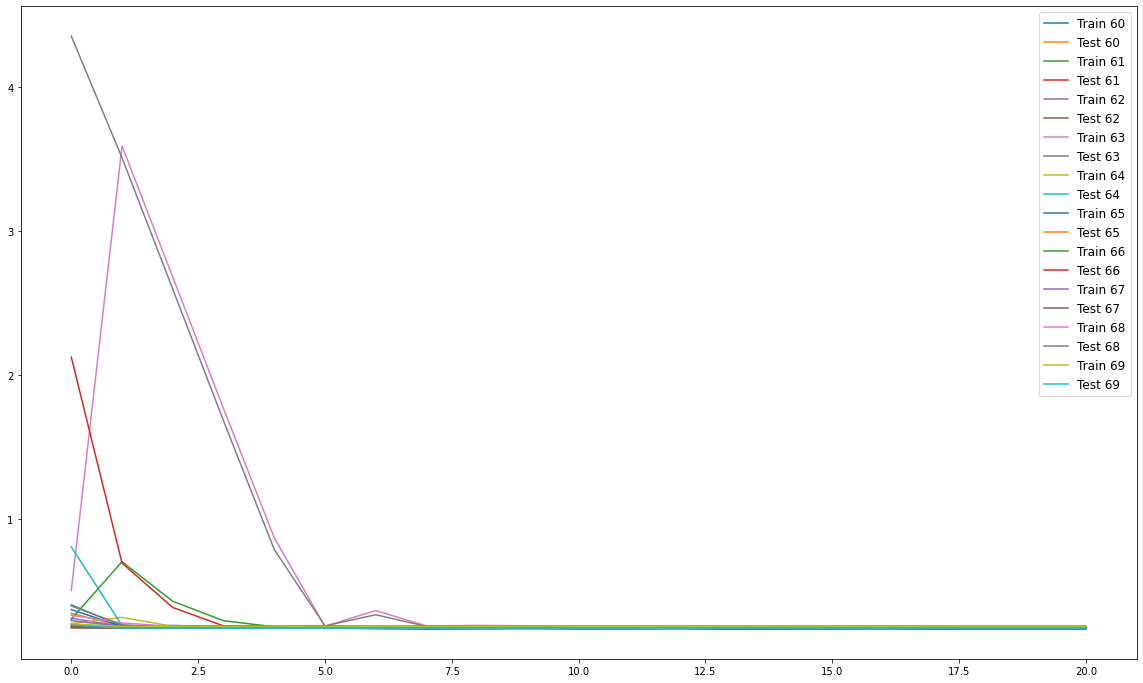

Номер сети: 70
Номер сети: 71
Номер сети: 72
Номер сети: 73
Номер сети: 74
Номер сети: 75
Номер сети: 76
Номер сети: 77
Номер сети: 78
Номер сети: 79


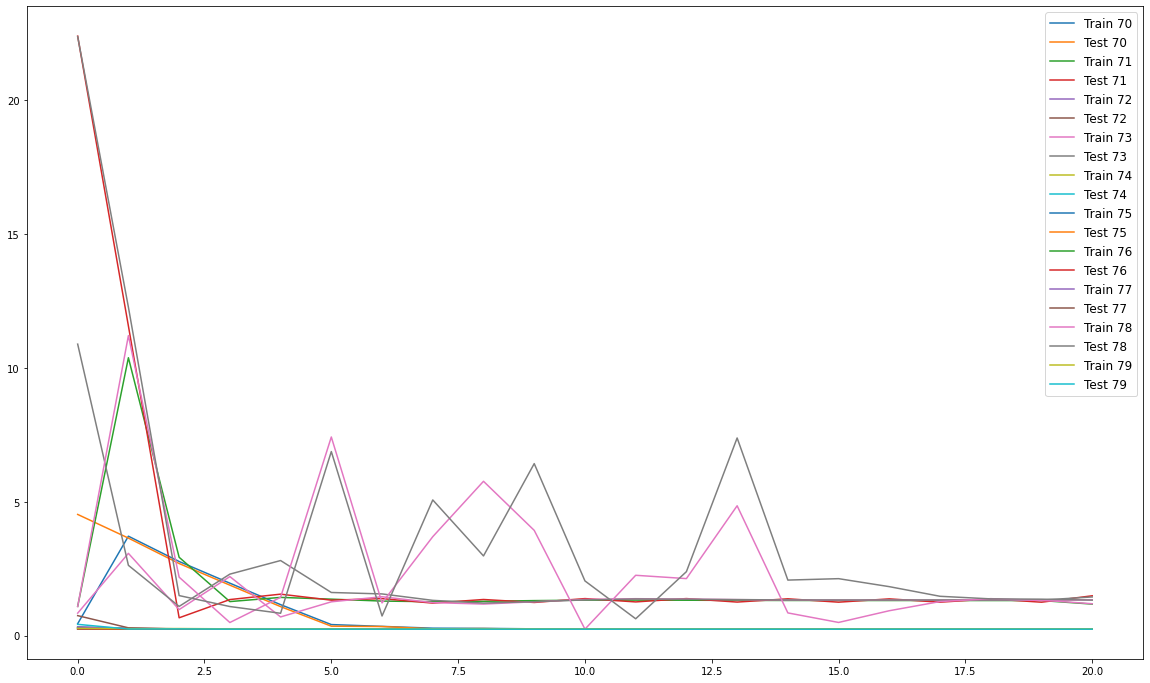

Номер сети: 80
Номер сети: 81
Номер сети: 82
Номер сети: 83
Номер сети: 84
Номер сети: 85
Номер сети: 86
Номер сети: 87
Номер сети: 88
Номер сети: 89


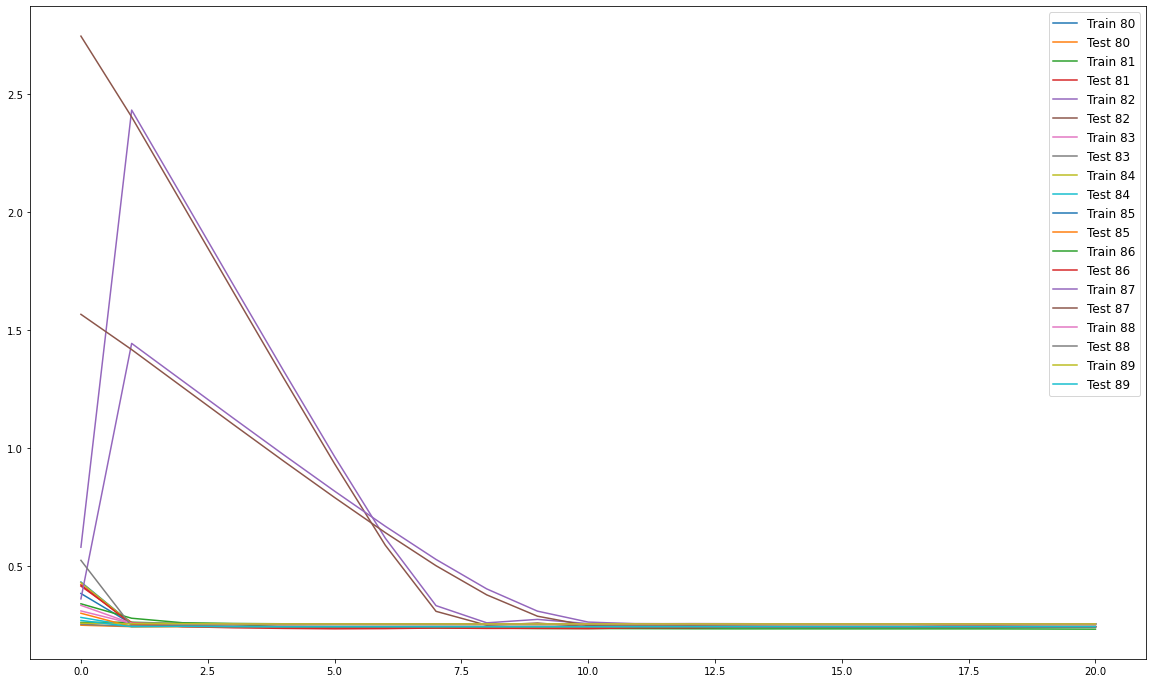

Номер сети: 90
Номер сети: 91
Номер сети: 92
Номер сети: 93
Номер сети: 94
Номер сети: 95
Номер сети: 96
Номер сети: 97
Номер сети: 98
Номер сети: 99


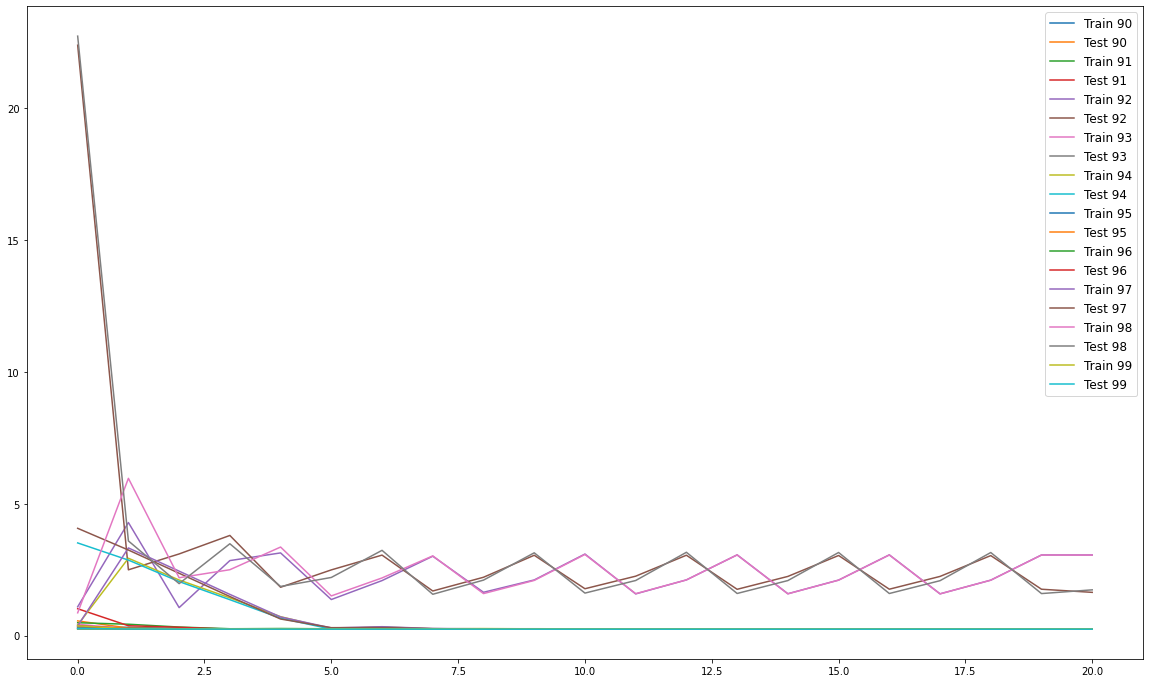

Номер сети: 100
Номер сети: 101
Номер сети: 102
Номер сети: 103
Номер сети: 104
Номер сети: 105
Номер сети: 106
Номер сети: 107
Номер сети: 108
Номер сети: 109


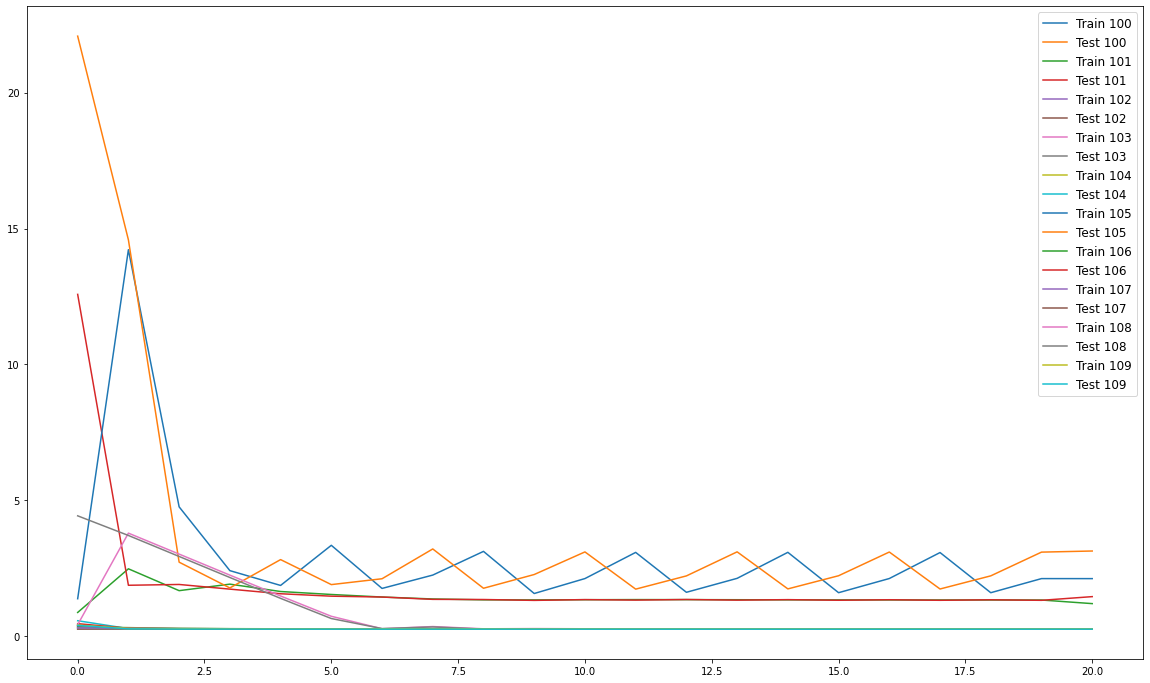

Номер сети: 110
Номер сети: 111
Номер сети: 112
Номер сети: 113
Номер сети: 114
Номер сети: 115
Номер сети: 116
Номер сети: 117
Номер сети: 118
Номер сети: 119


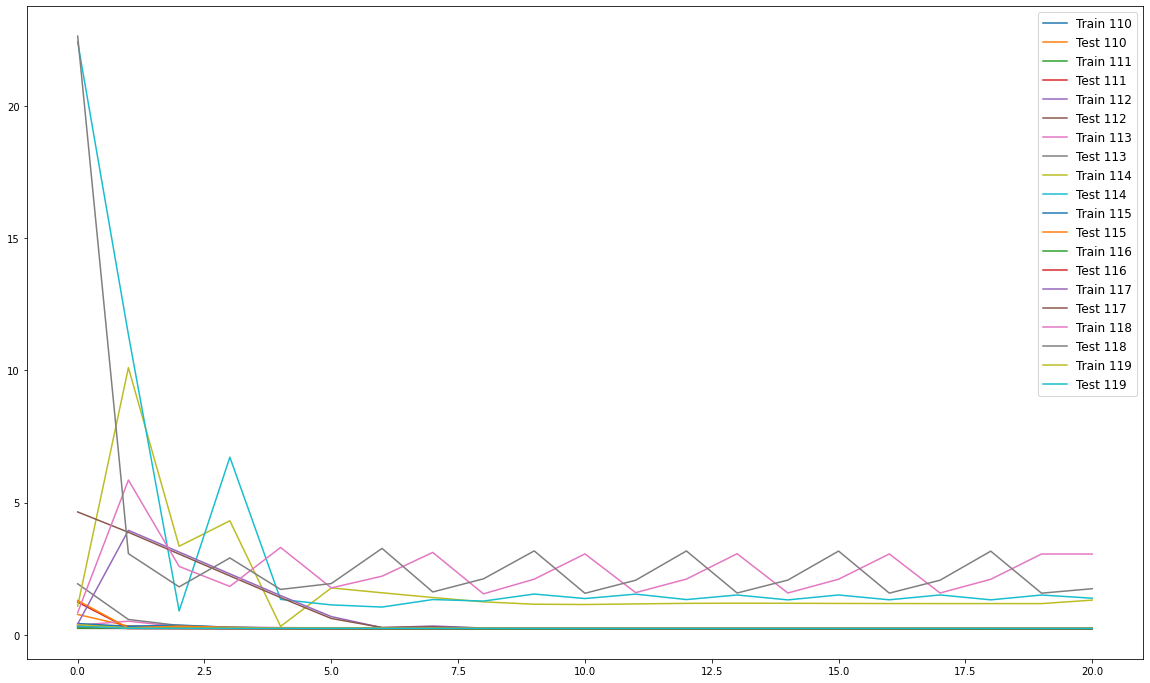

Номер сети: 120
Номер сети: 121
Номер сети: 122
Номер сети: 123
Номер сети: 124
Номер сети: 125
Номер сети: 126
Номер сети: 127
Номер сети: 128
Номер сети: 129


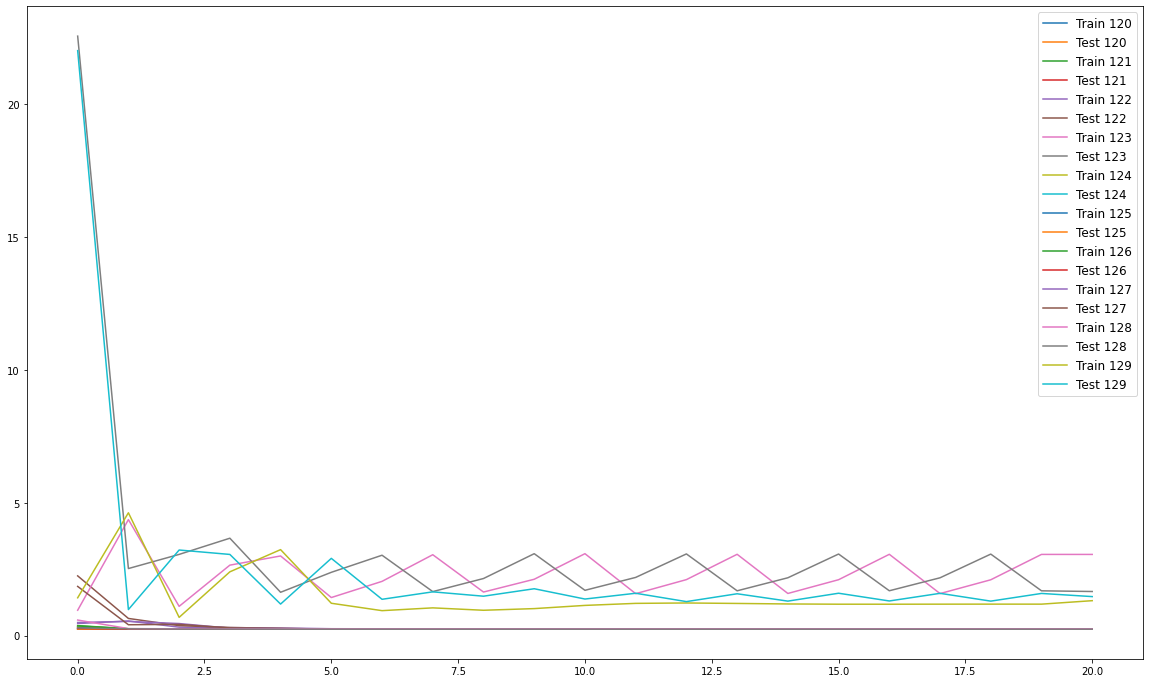

Номер сети: 130
Номер сети: 131
Номер сети: 132
Номер сети: 133
Номер сети: 134
Номер сети: 135
Номер сети: 136
Номер сети: 137
Номер сети: 138
Номер сети: 139


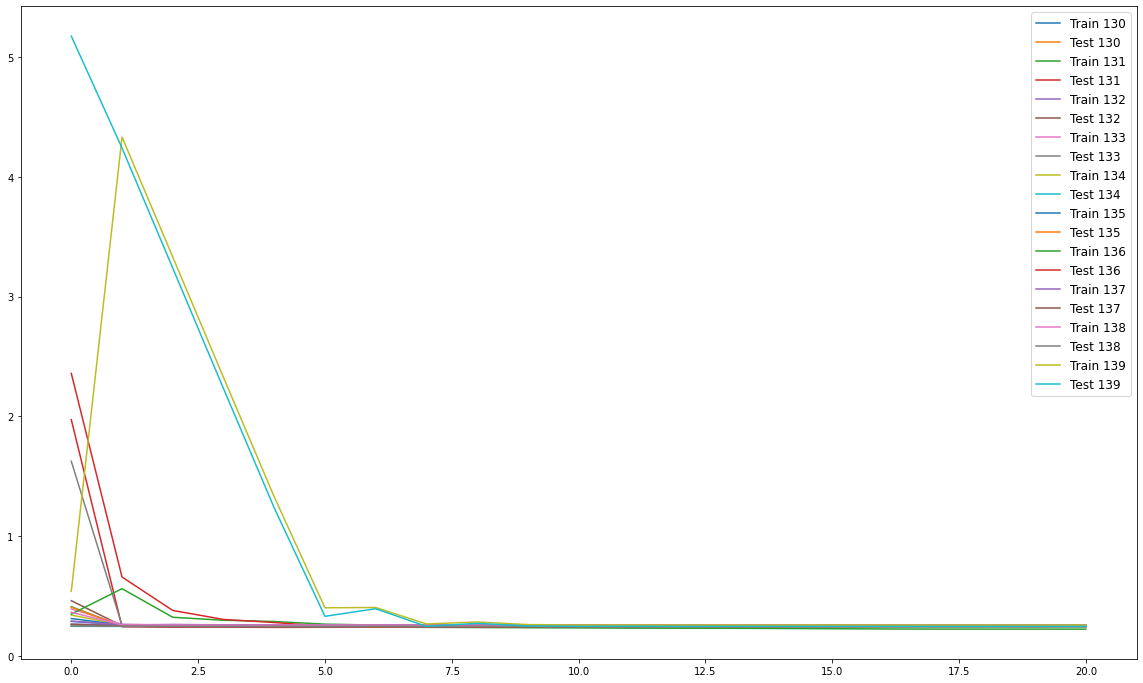

Номер сети: 140
Номер сети: 141
Номер сети: 142
Номер сети: 143
Номер сети: 144
Номер сети: 145
Номер сети: 146
Номер сети: 147
Номер сети: 148
Номер сети: 149


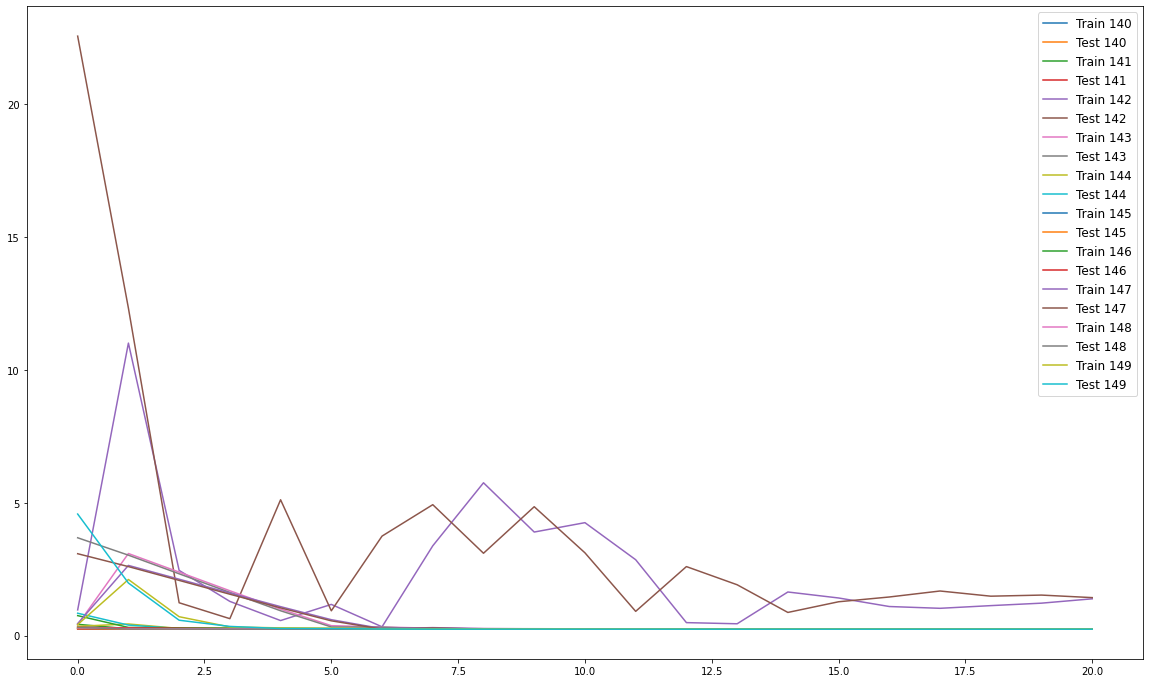

Номер сети: 150
Номер сети: 151
Номер сети: 152
Номер сети: 153
Номер сети: 154
Номер сети: 155
Номер сети: 156
Номер сети: 157
Номер сети: 158
Номер сети: 159


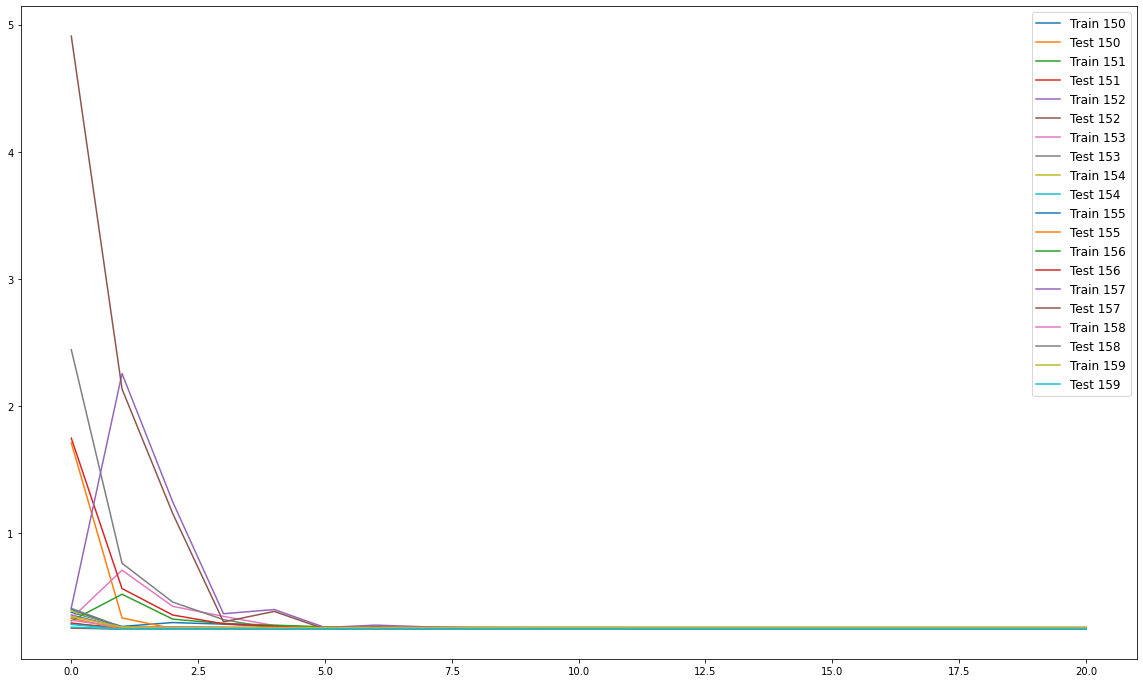

Номер сети: 160
Номер сети: 161
Номер сети: 162
Номер сети: 163
Номер сети: 164
Номер сети: 165
Номер сети: 166
Номер сети: 167
Номер сети: 168
Номер сети: 169


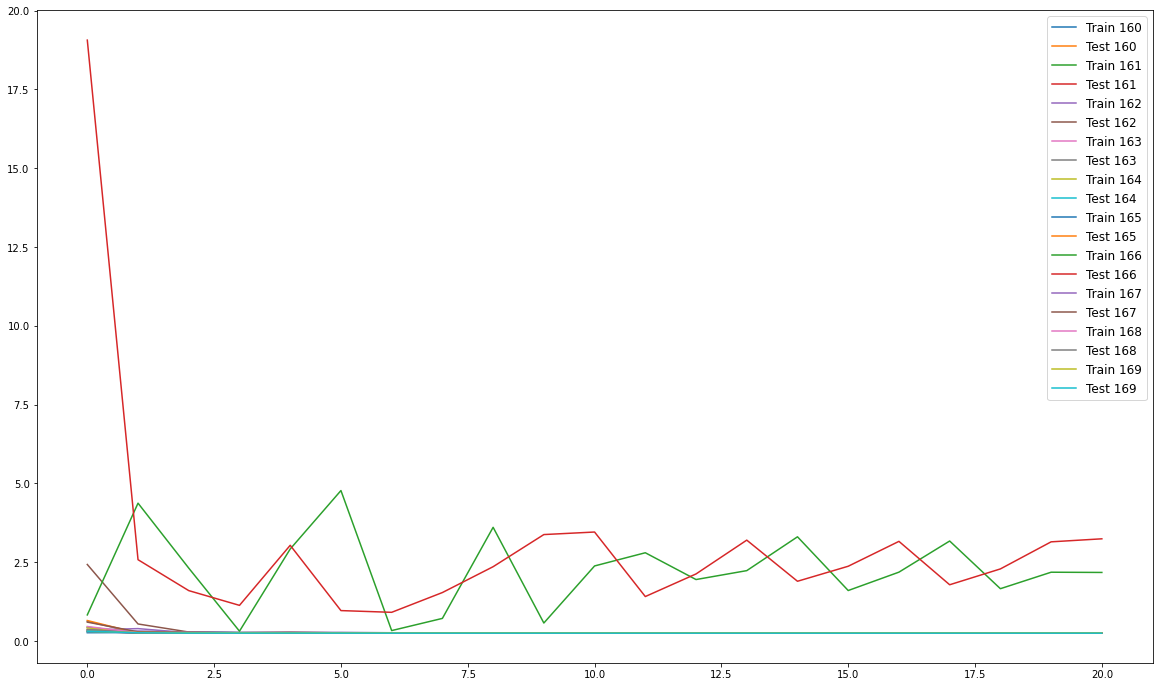

Номер сети: 170
Номер сети: 171
Номер сети: 172
Номер сети: 173
Номер сети: 174
Номер сети: 175
Номер сети: 176
Номер сети: 177
Номер сети: 178
Номер сети: 179


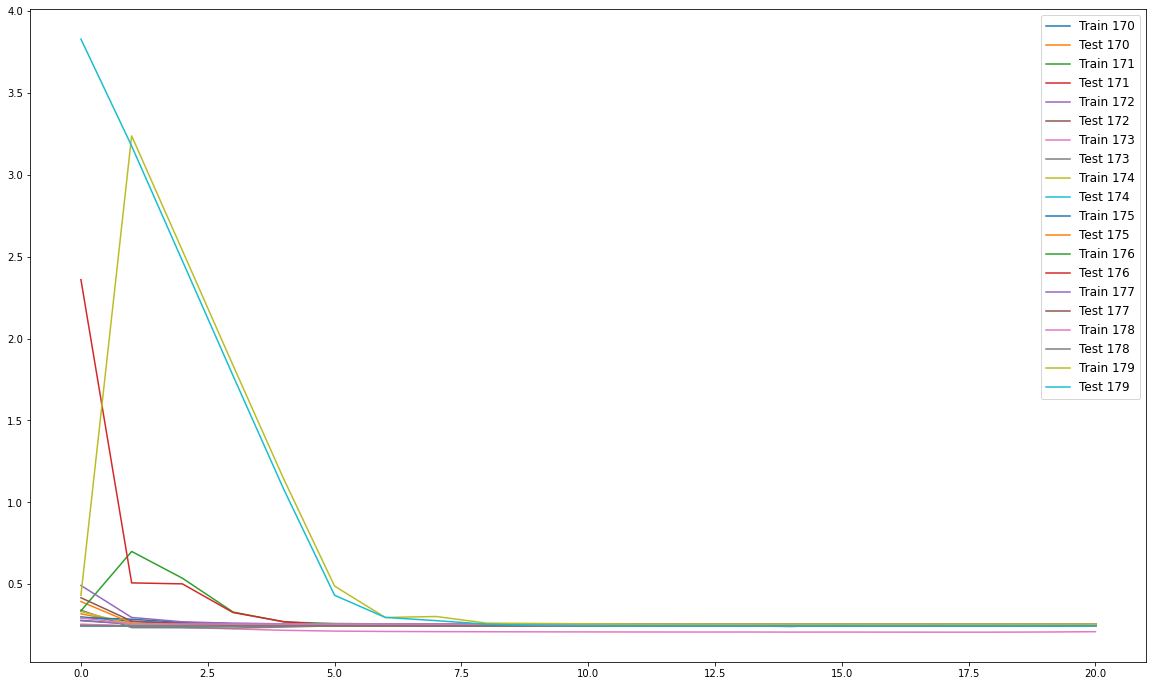

Номер сети: 180
Номер сети: 181
Номер сети: 182
Номер сети: 183
Номер сети: 184
Номер сети: 185
Номер сети: 186
Номер сети: 187
Номер сети: 188
Номер сети: 189


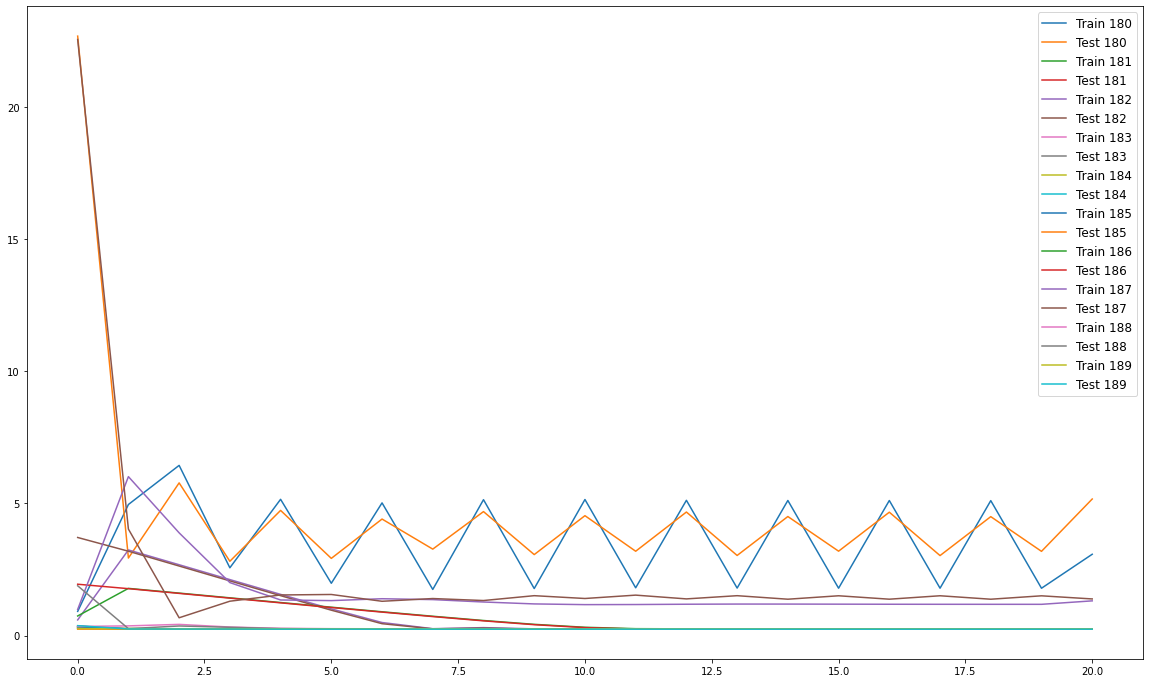

Номер сети: 190
Номер сети: 191
Номер сети: 192
Номер сети: 193
Номер сети: 194
Номер сети: 195
Номер сети: 196
Номер сети: 197
Номер сети: 198
Номер сети: 199


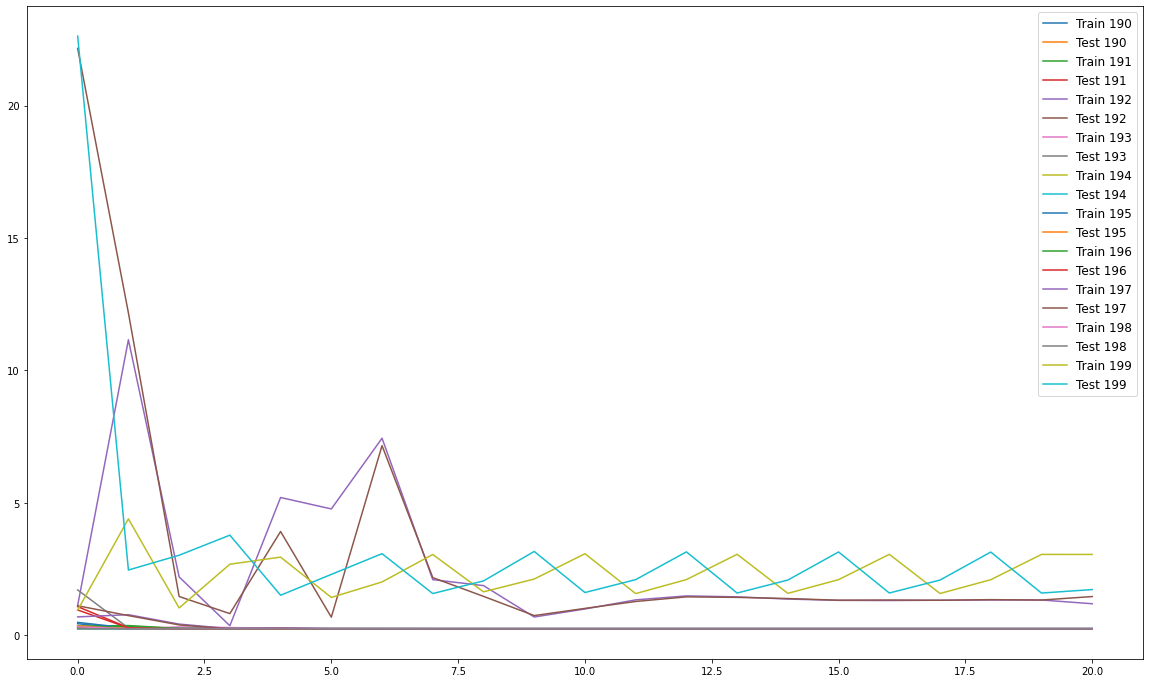

Номер сети: 200
Номер сети: 201
Номер сети: 202
Номер сети: 203
Номер сети: 204
Номер сети: 205
Номер сети: 206
Номер сети: 207
Номер сети: 208
Номер сети: 209


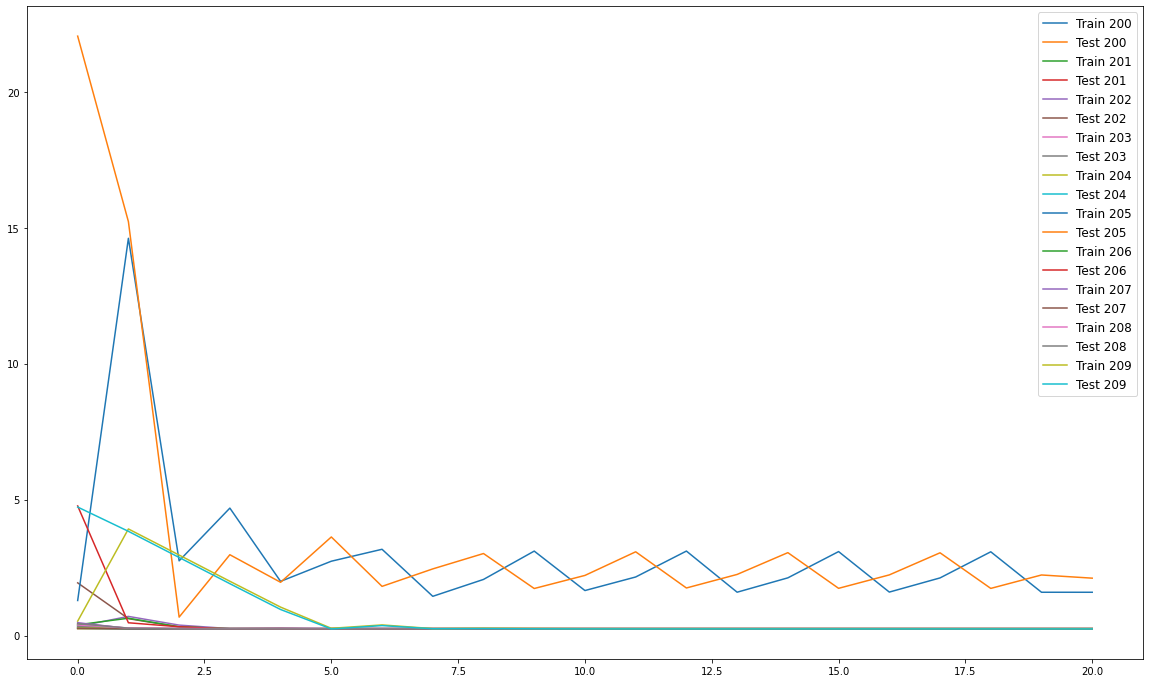

Номер сети: 210
Номер сети: 211
Номер сети: 212
Номер сети: 213
Номер сети: 214
Номер сети: 215
Номер сети: 216
Номер сети: 217
Номер сети: 218
Номер сети: 219


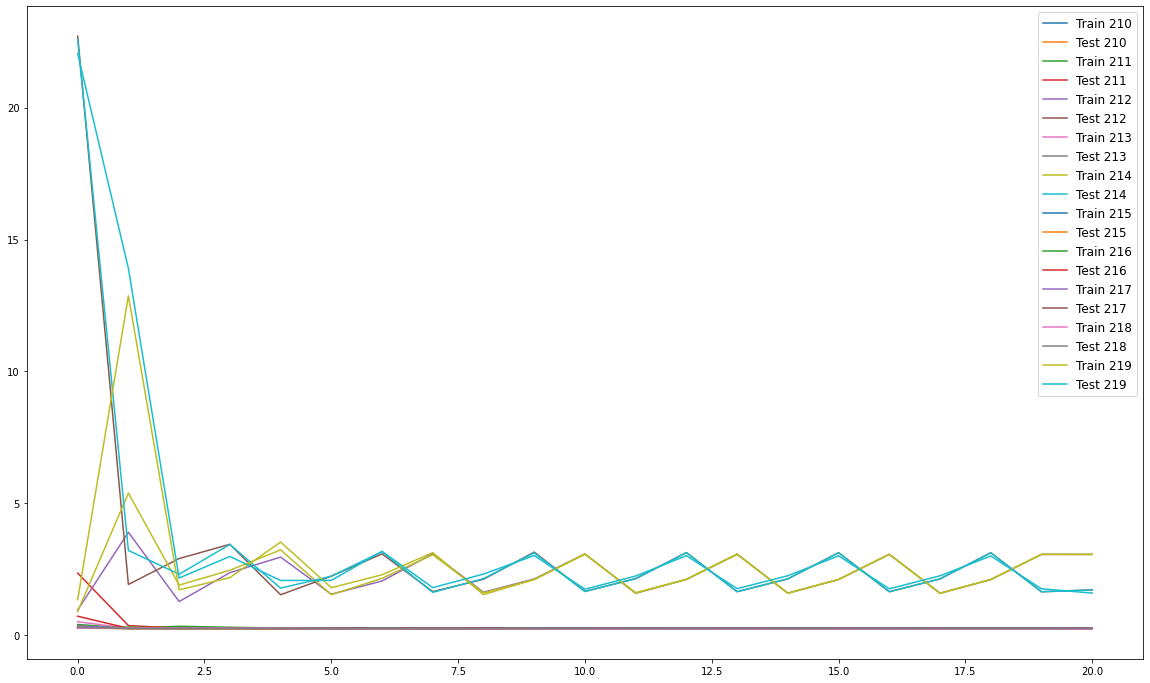

Номер сети: 220
Номер сети: 221
Номер сети: 222
Номер сети: 223
Номер сети: 224
Номер сети: 225
Номер сети: 226
Номер сети: 227
Номер сети: 228
Номер сети: 229


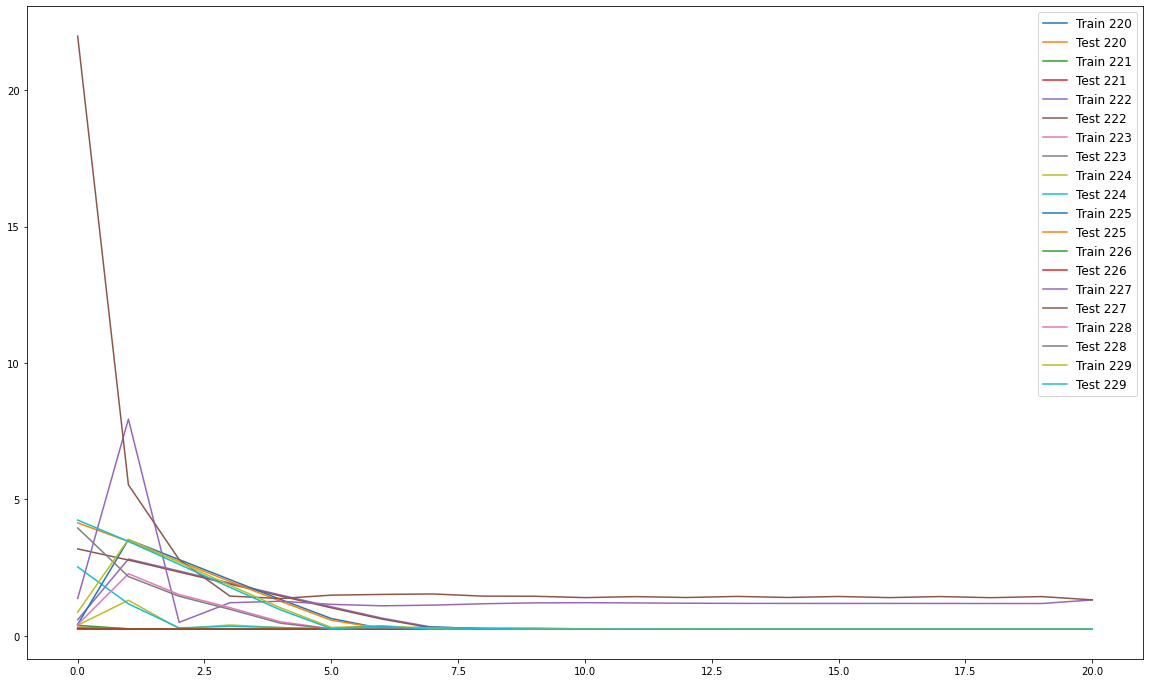

Номер сети: 230
Номер сети: 231
Номер сети: 232
Номер сети: 233
Номер сети: 234
Номер сети: 235
Номер сети: 236
Номер сети: 237
Номер сети: 238
Номер сети: 239


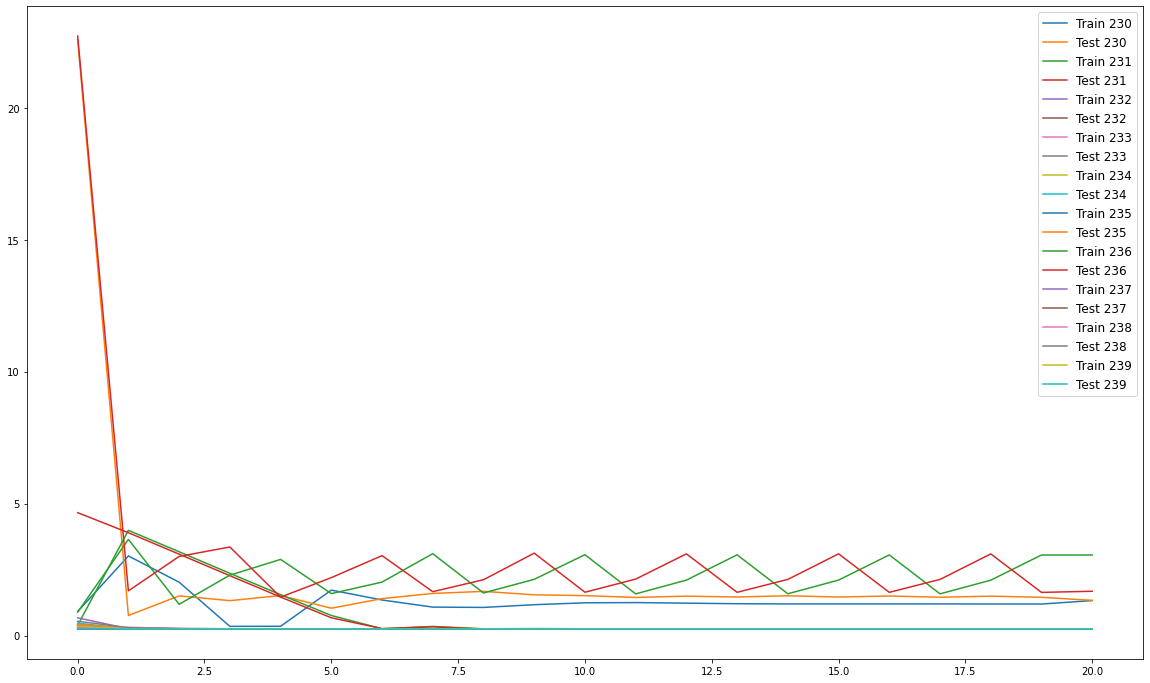

Номер сети: 240
Номер сети: 241
Номер сети: 242
Номер сети: 243
Номер сети: 244
Номер сети: 245
Номер сети: 246
Номер сети: 247
Номер сети: 248
Номер сети: 249


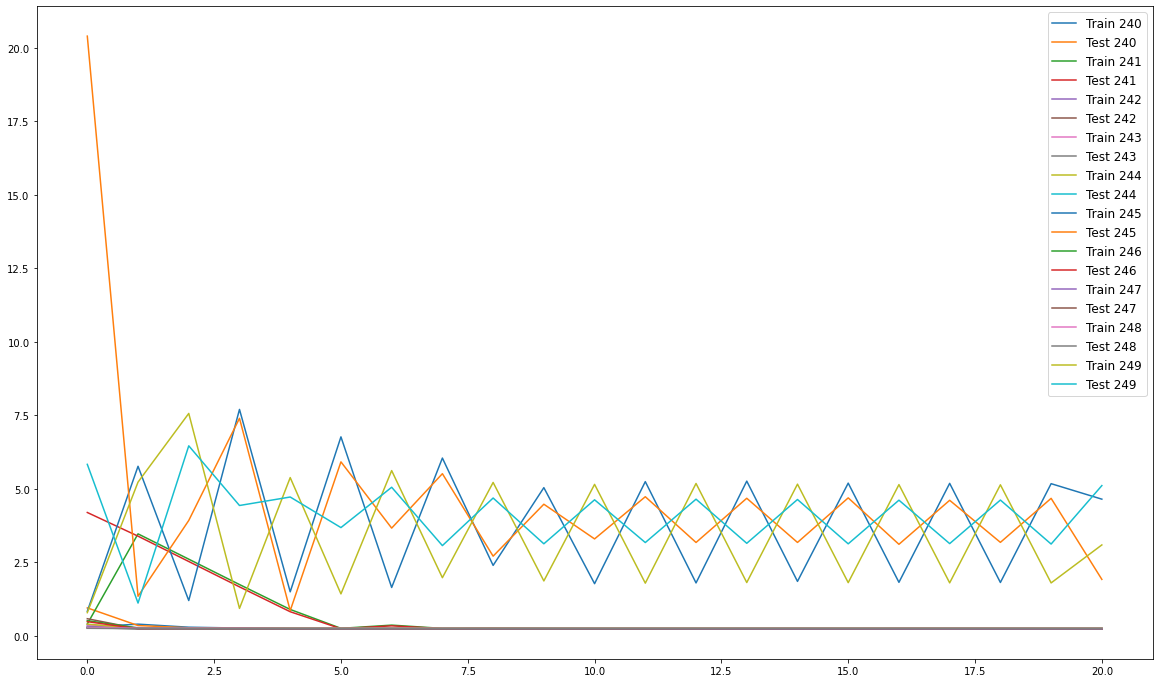

Номер сети: 250
Номер сети: 251
Номер сети: 252
Номер сети: 253
Номер сети: 254
Номер сети: 255
Номер сети: 256
Номер сети: 257
Номер сети: 258
Номер сети: 259


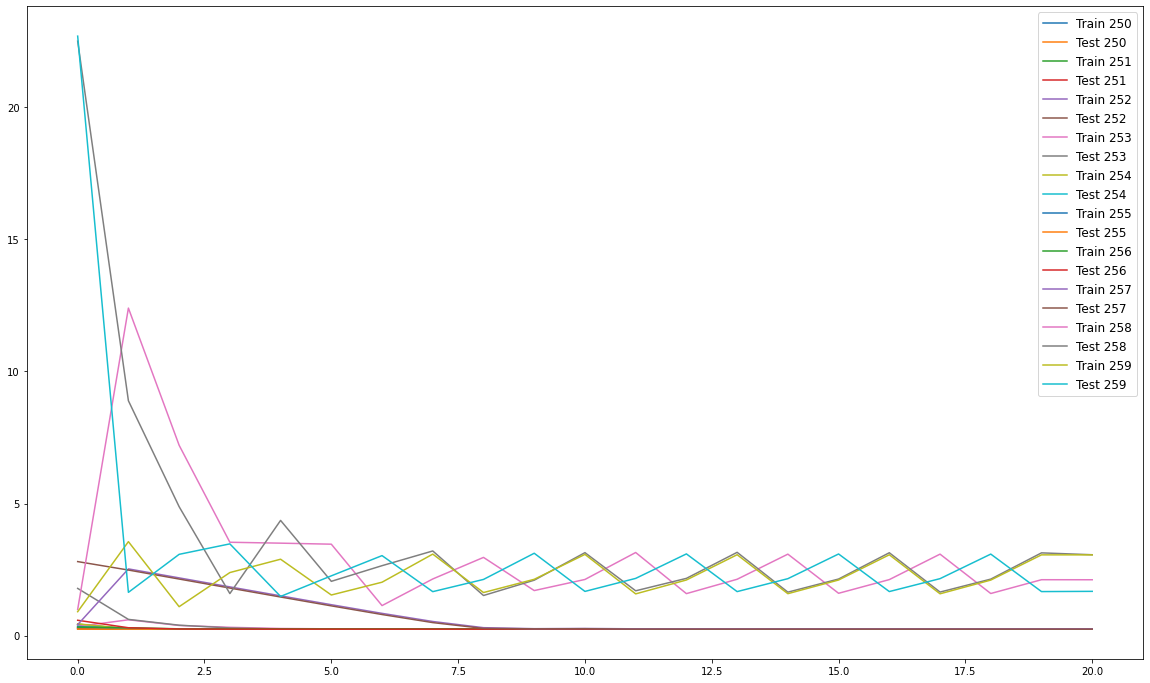

Номер сети: 260
Номер сети: 261
Номер сети: 262
Номер сети: 263
Номер сети: 264
Номер сети: 265
Номер сети: 266
Номер сети: 267
Номер сети: 268
Номер сети: 269


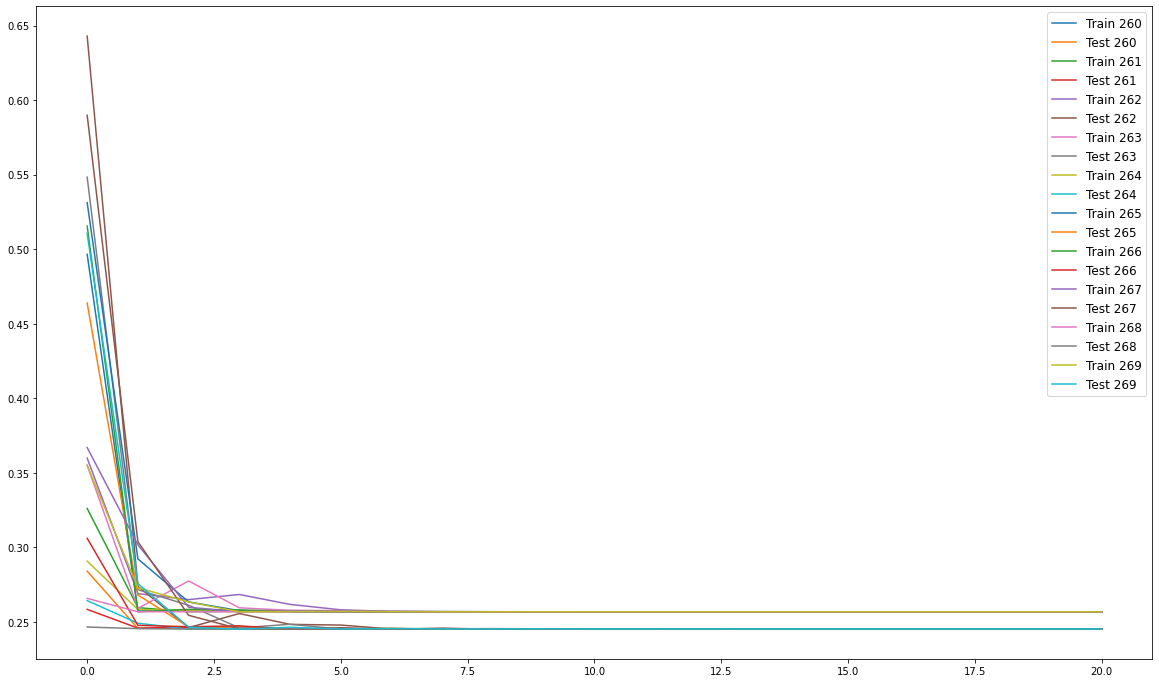

Номер сети: 270
Номер сети: 271
Номер сети: 272
Номер сети: 273
Номер сети: 274
Номер сети: 275
Номер сети: 276
Номер сети: 277
Номер сети: 278
Номер сети: 279


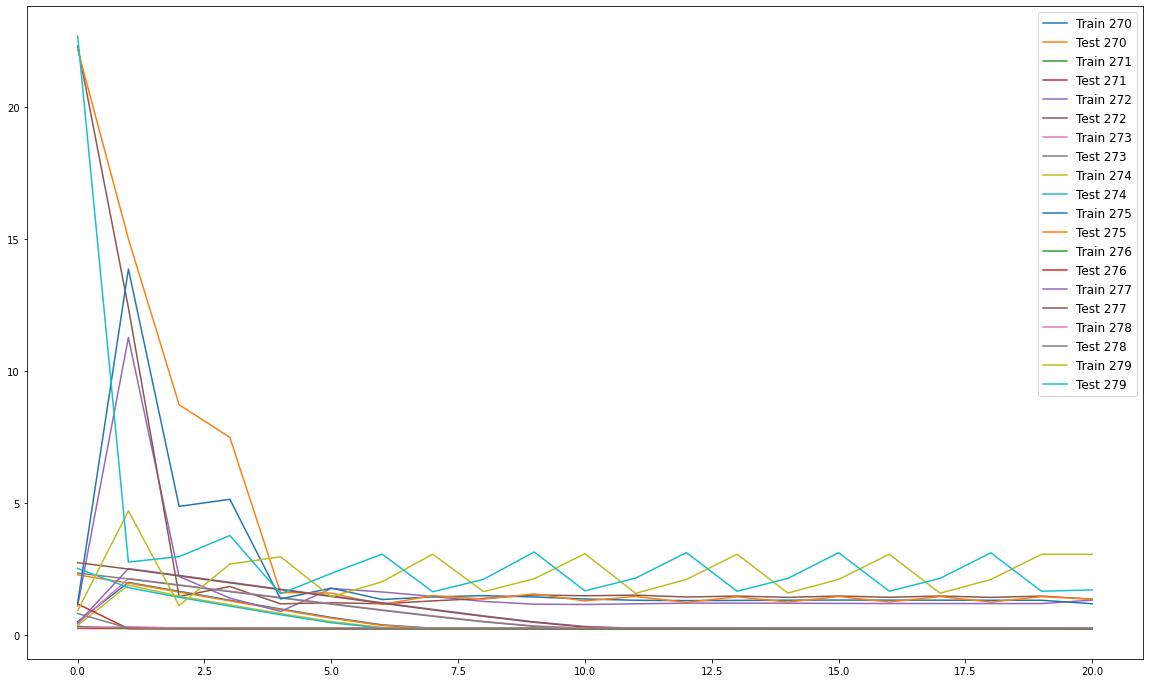

Номер сети: 280
Номер сети: 281
Номер сети: 282
Номер сети: 283
Номер сети: 284
Номер сети: 285
Номер сети: 286
Номер сети: 287
Номер сети: 288
Номер сети: 289


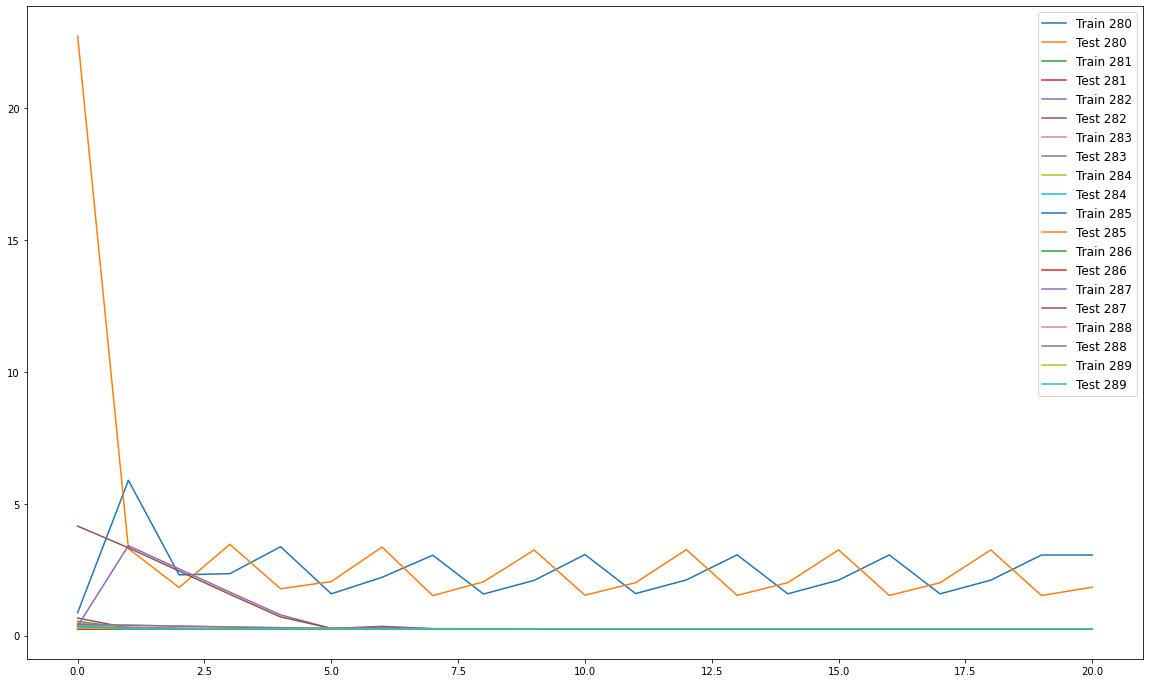

Номер сети: 290
Номер сети: 291
Номер сети: 292
Номер сети: 293
Номер сети: 294
Номер сети: 295
Номер сети: 296
Номер сети: 297
Номер сети: 298
Номер сети: 299


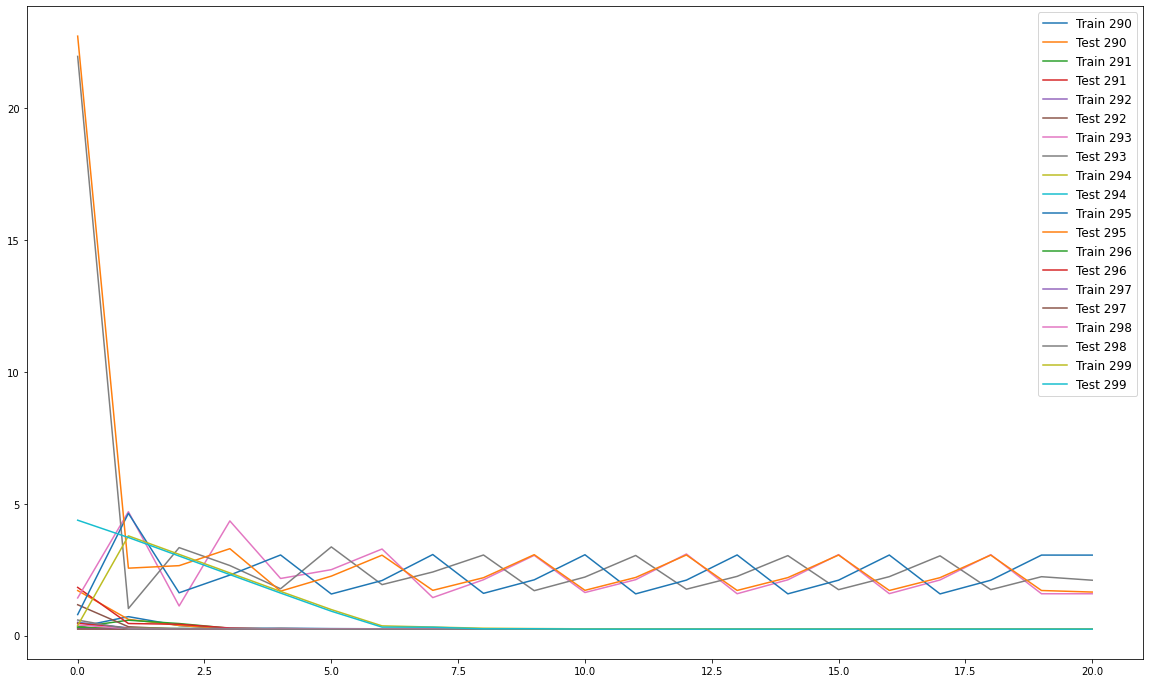

Номер сети: 300
Номер сети: 301
Номер сети: 302
Номер сети: 303
Номер сети: 304
Номер сети: 305
Номер сети: 306
Номер сети: 307
Номер сети: 308
Номер сети: 309


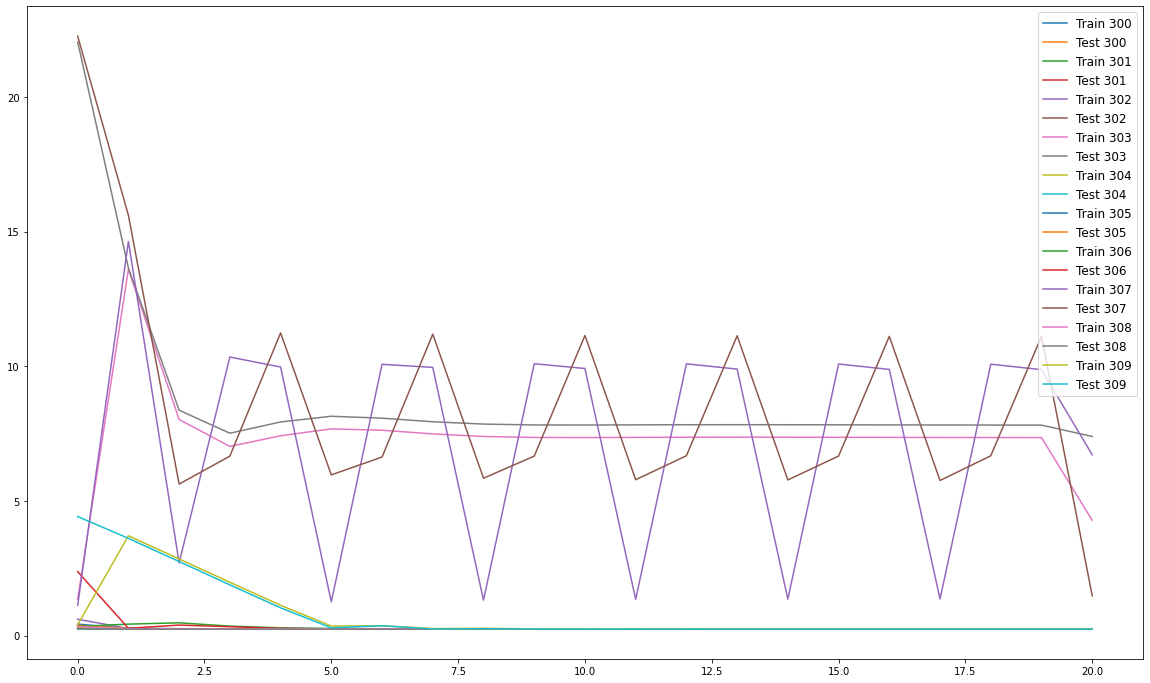

Номер сети: 310
Номер сети: 311
Номер сети: 312
Номер сети: 313
Номер сети: 314
Номер сети: 315
Номер сети: 316
Номер сети: 317
Номер сети: 318
Номер сети: 319


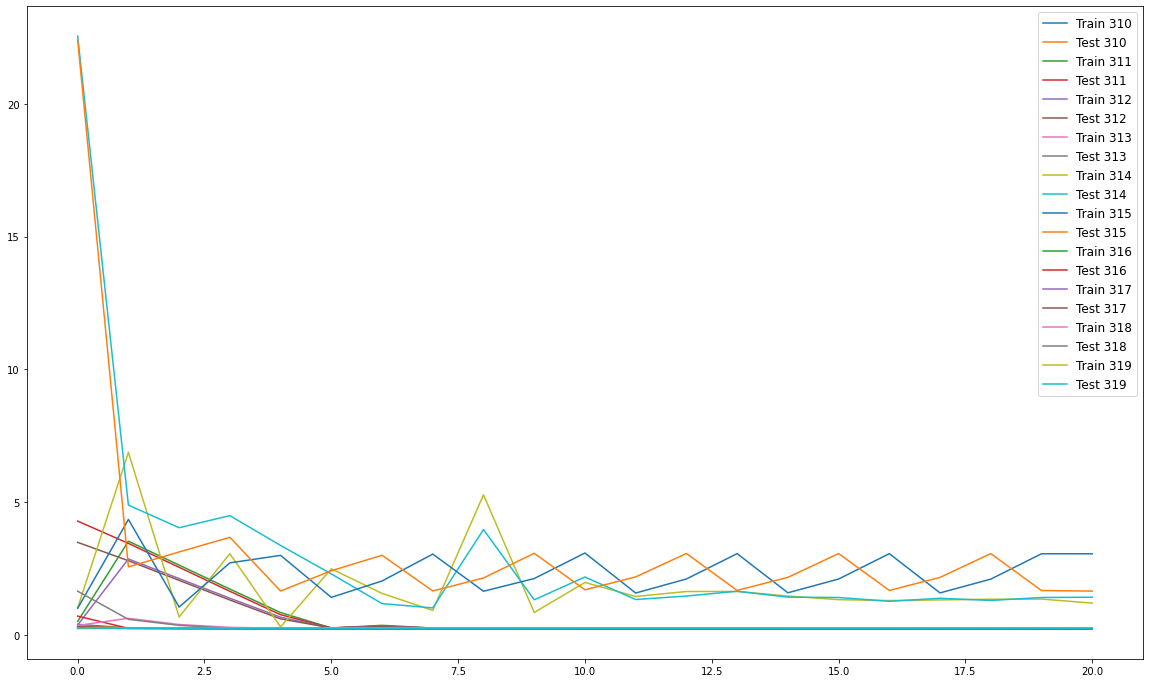

Номер сети: 320
Номер сети: 321
Номер сети: 322
Номер сети: 323
Номер сети: 324
Номер сети: 325
Номер сети: 326
Номер сети: 327
Номер сети: 328
Номер сети: 329


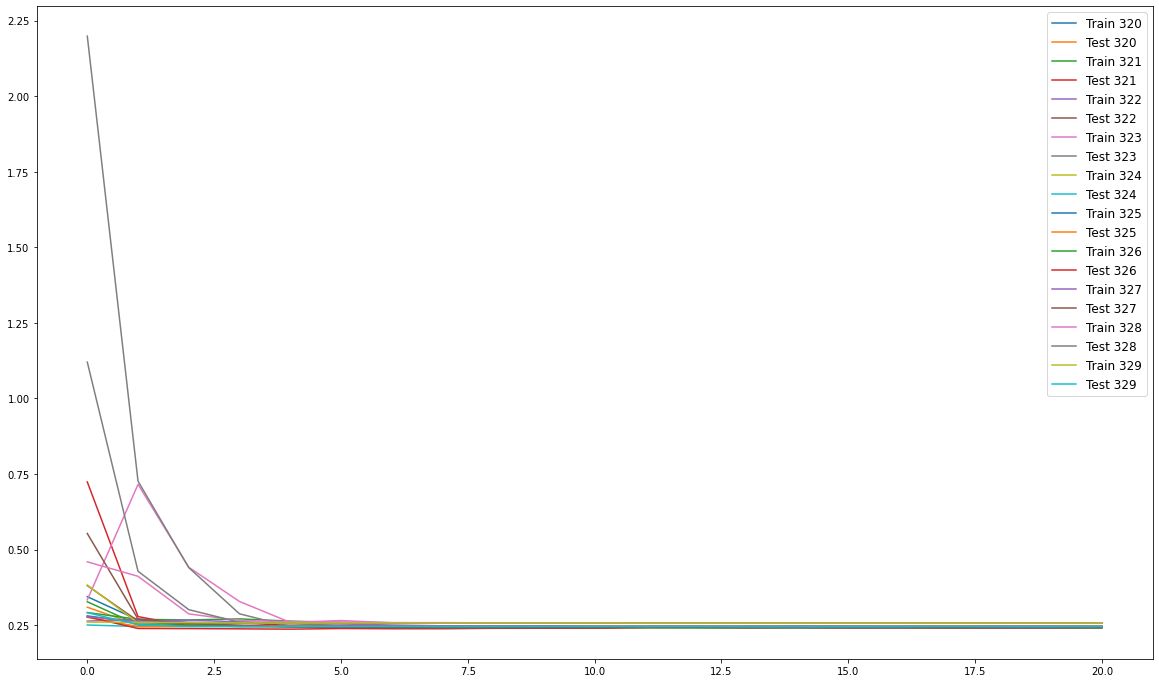

Номер сети: 330
Номер сети: 331
Номер сети: 332
Номер сети: 333
Номер сети: 334
Номер сети: 335
Номер сети: 336
Номер сети: 337
Номер сети: 338
Номер сети: 339


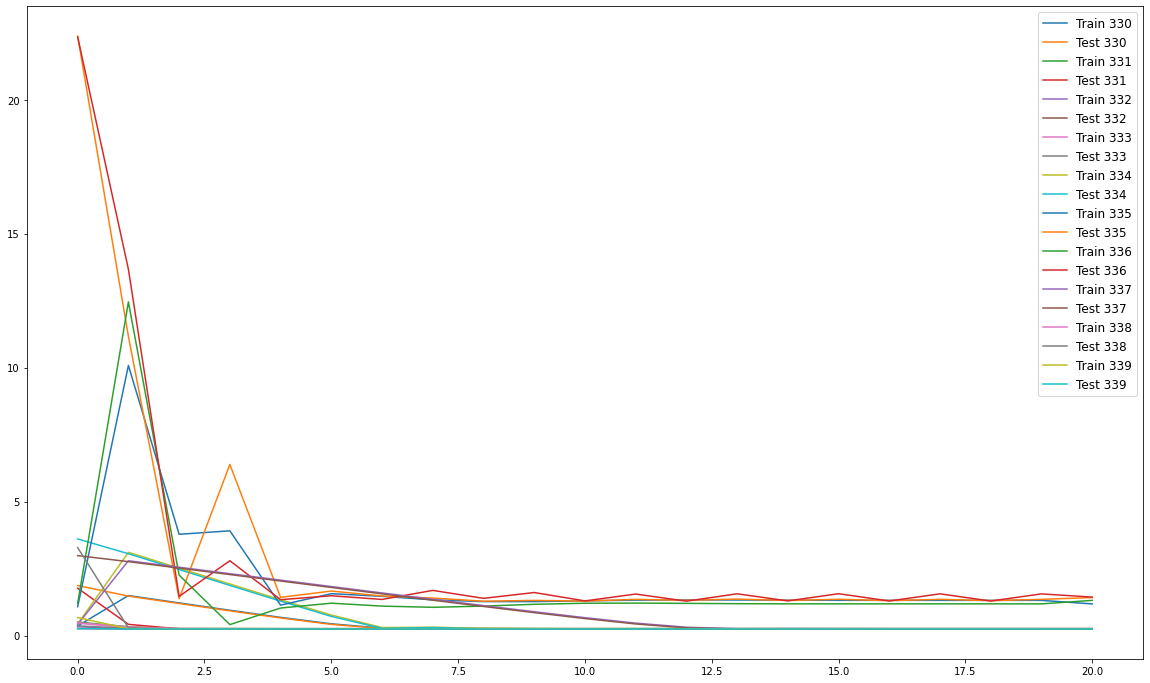

Номер сети: 340
Номер сети: 341
Номер сети: 342
Номер сети: 343
Номер сети: 344
Номер сети: 345
Номер сети: 346
Номер сети: 347
Номер сети: 348
Номер сети: 349


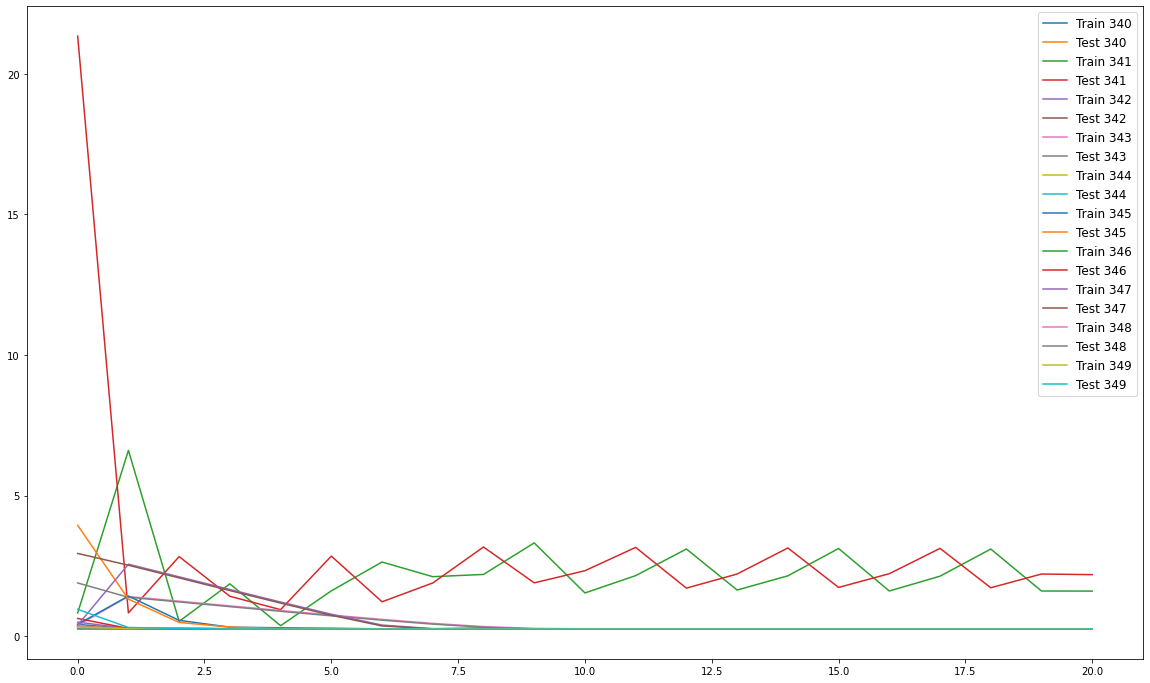

Номер сети: 350
Номер сети: 351
Номер сети: 352
Номер сети: 353
Номер сети: 354
Номер сети: 355
Номер сети: 356
Номер сети: 357
Номер сети: 358
Номер сети: 359


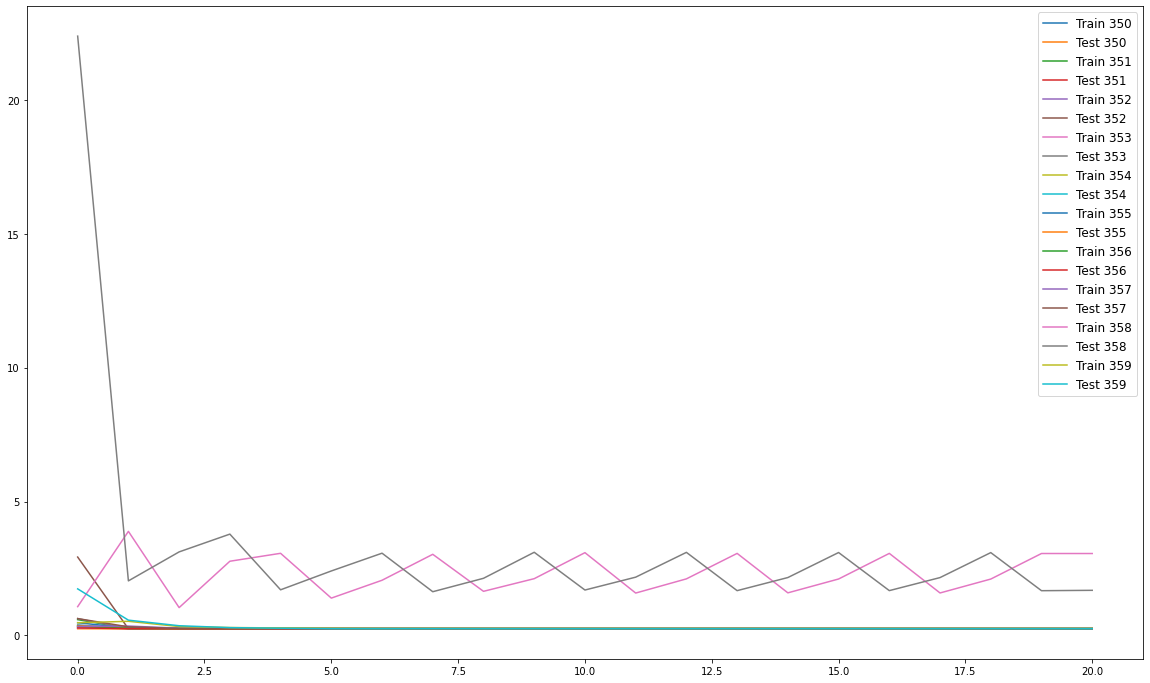

Номер сети: 360
Номер сети: 361
Номер сети: 362
Номер сети: 363
Номер сети: 364
Номер сети: 365
Номер сети: 366
Номер сети: 367
Номер сети: 368
Номер сети: 369


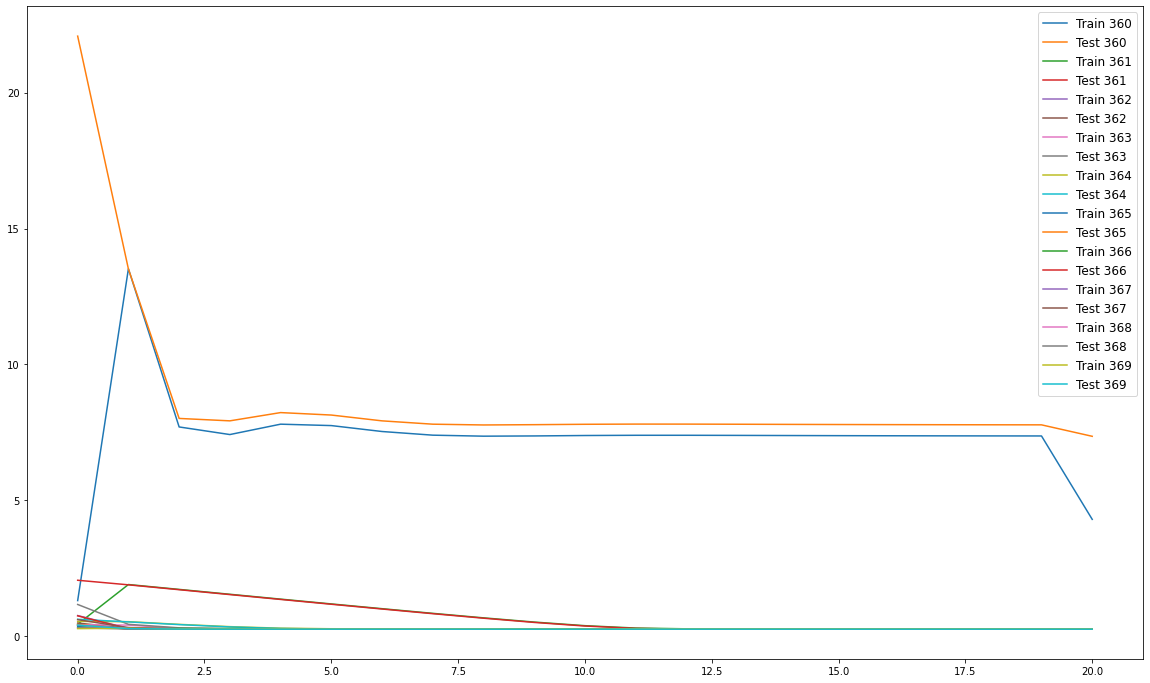

Номер сети: 370
Номер сети: 371
Номер сети: 372
Номер сети: 373
Номер сети: 374
Номер сети: 375
Номер сети: 376
Номер сети: 377
Номер сети: 378
Номер сети: 379


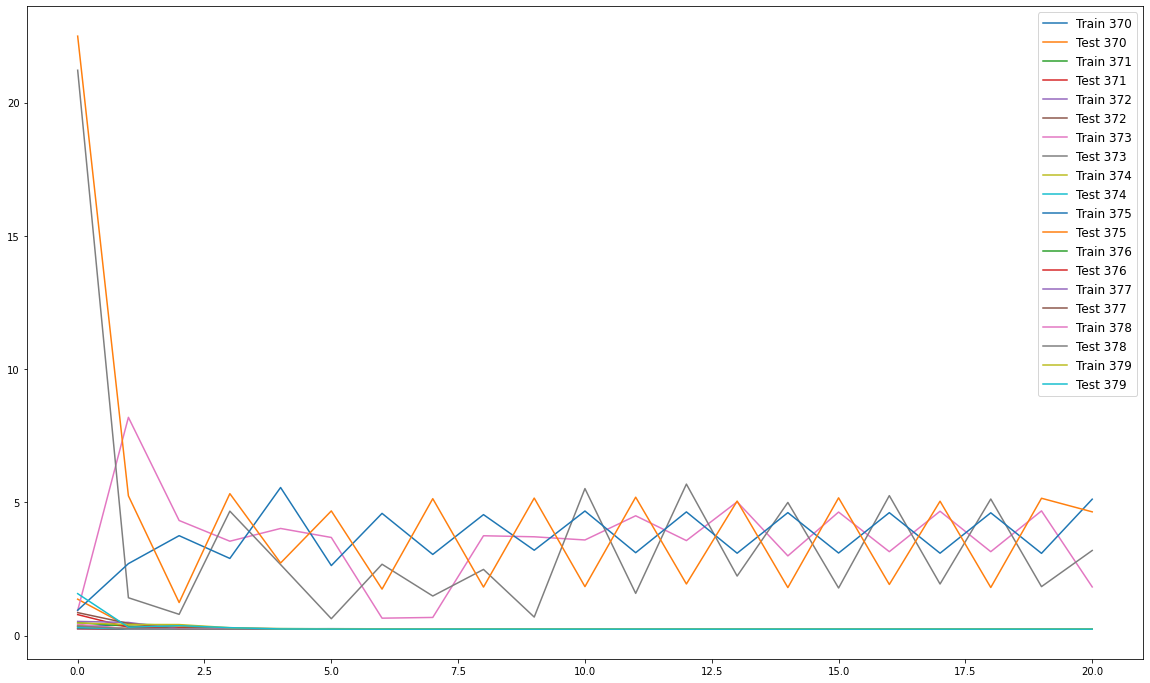

Номер сети: 380
Номер сети: 381
Номер сети: 382
Номер сети: 383
Номер сети: 384
Номер сети: 385
Номер сети: 386
Номер сети: 387
Номер сети: 388
Номер сети: 389


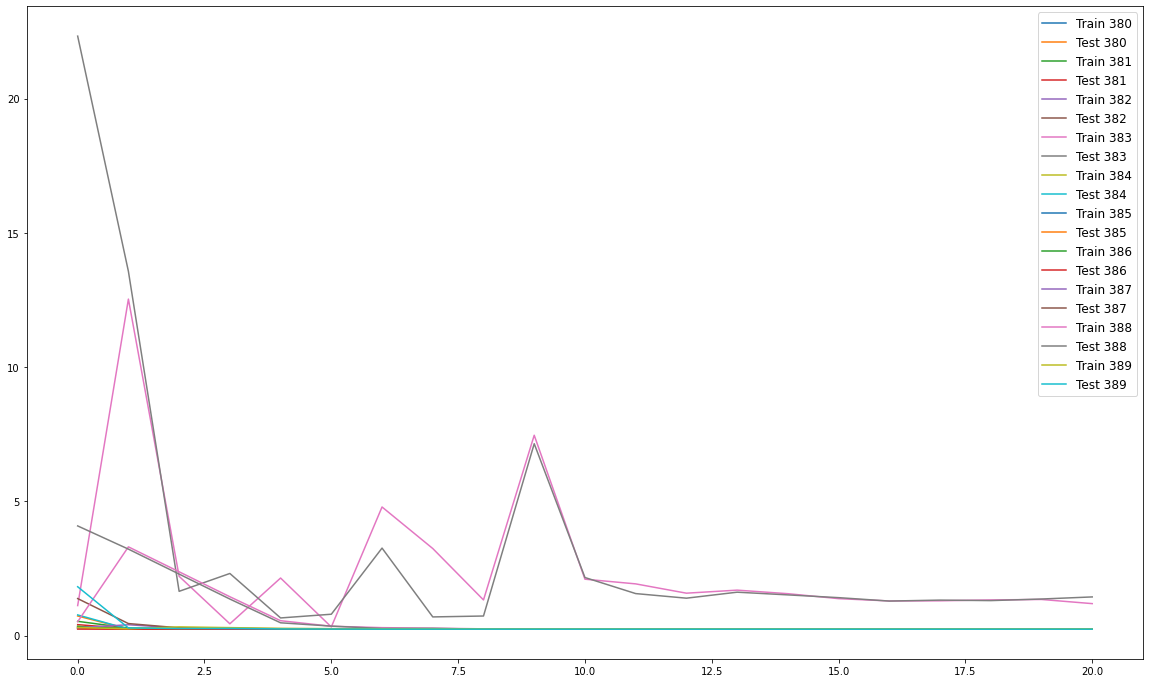

Номер сети: 390
Номер сети: 391
Номер сети: 392
Номер сети: 393
Номер сети: 394
Номер сети: 395
Номер сети: 396
Номер сети: 397
Номер сети: 398
Номер сети: 399


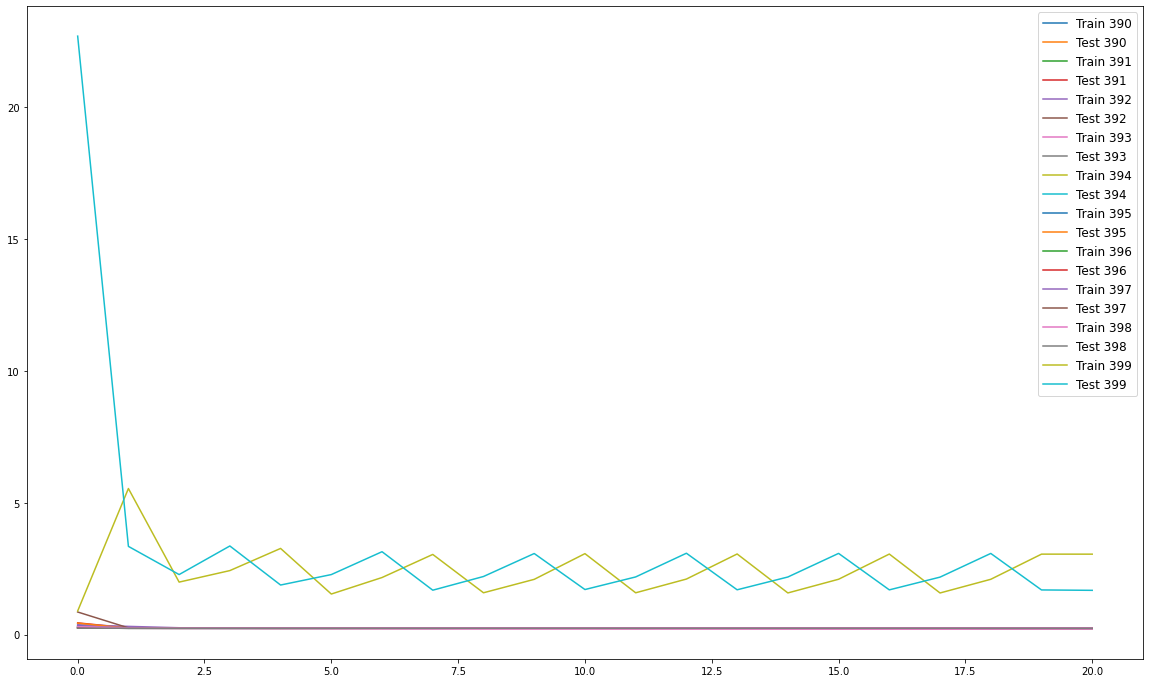

Номер сети: 400
Номер сети: 401
Номер сети: 402
Номер сети: 403
Номер сети: 404
Номер сети: 405
Номер сети: 406
Номер сети: 407
Номер сети: 408
Номер сети: 409


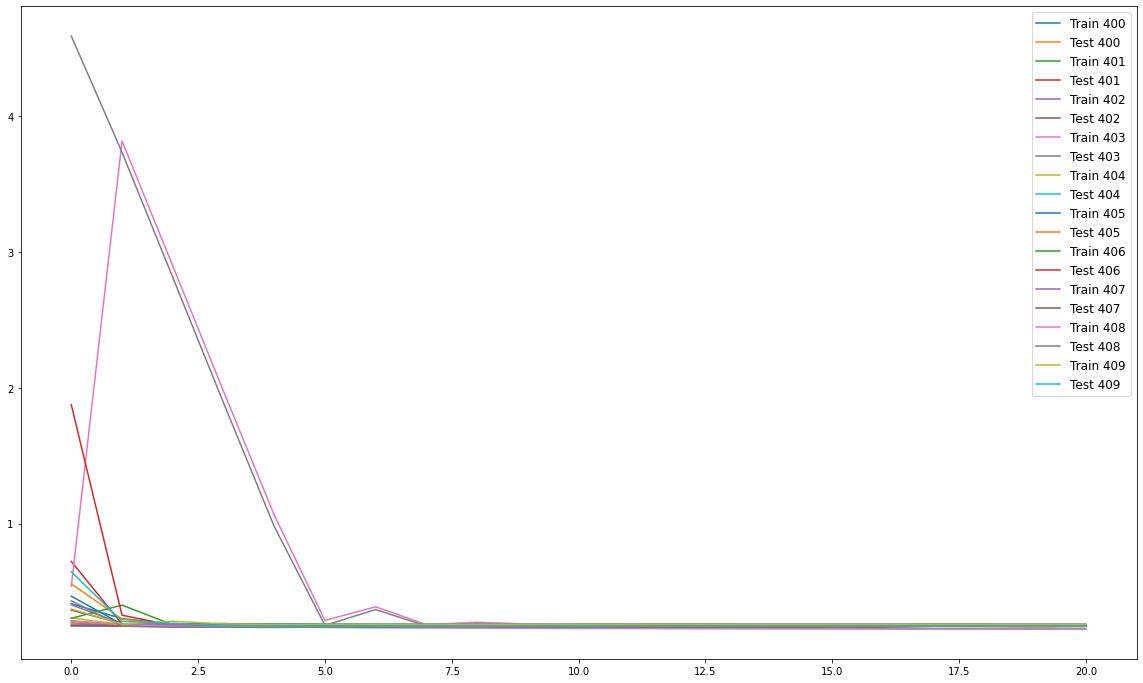

Номер сети: 410
Номер сети: 411
Номер сети: 412
Номер сети: 413
Номер сети: 414
Номер сети: 415
Номер сети: 416
Номер сети: 417
Номер сети: 418
Номер сети: 419


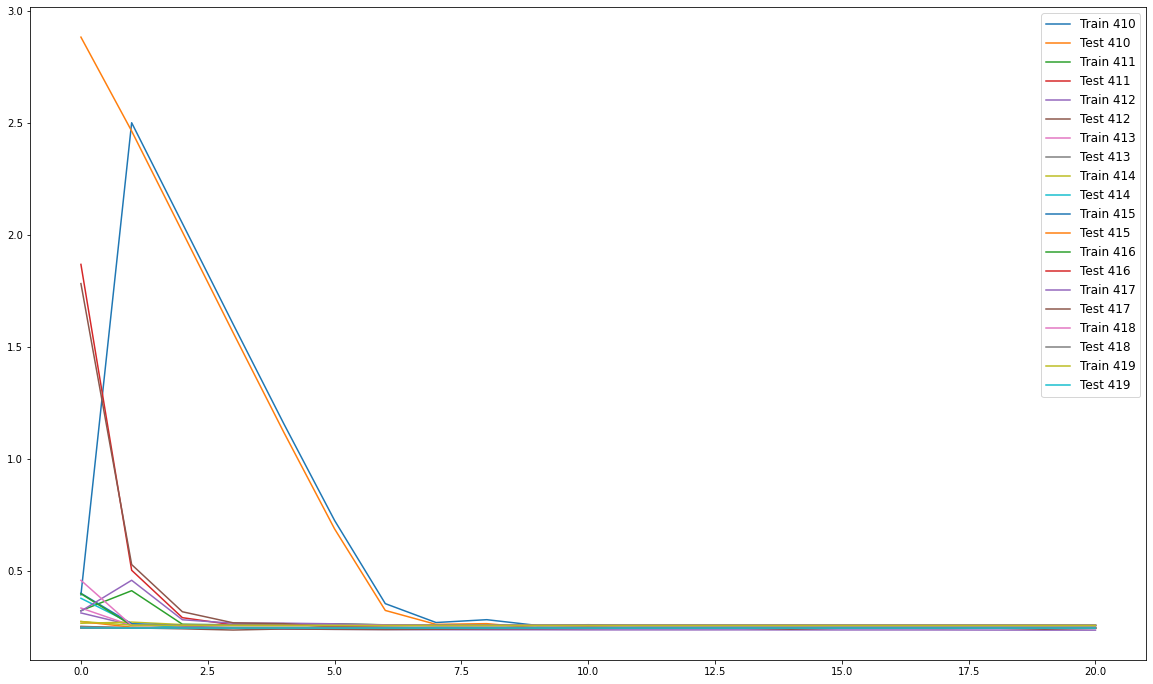

Номер сети: 420
Номер сети: 421
Номер сети: 422
Номер сети: 423
Номер сети: 424
Номер сети: 425
Номер сети: 426
Номер сети: 427
Номер сети: 428
Номер сети: 429


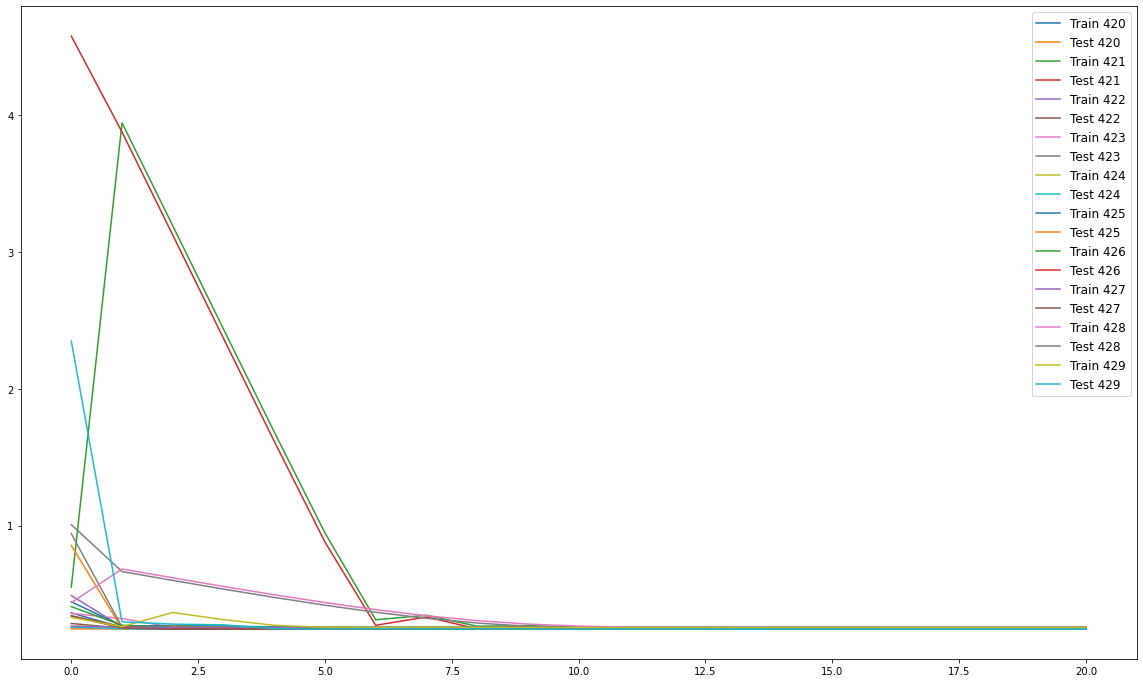

Номер сети: 430
Номер сети: 431
Номер сети: 432
Номер сети: 433
Номер сети: 434
Номер сети: 435
Номер сети: 436
Номер сети: 437
Номер сети: 438
Номер сети: 439


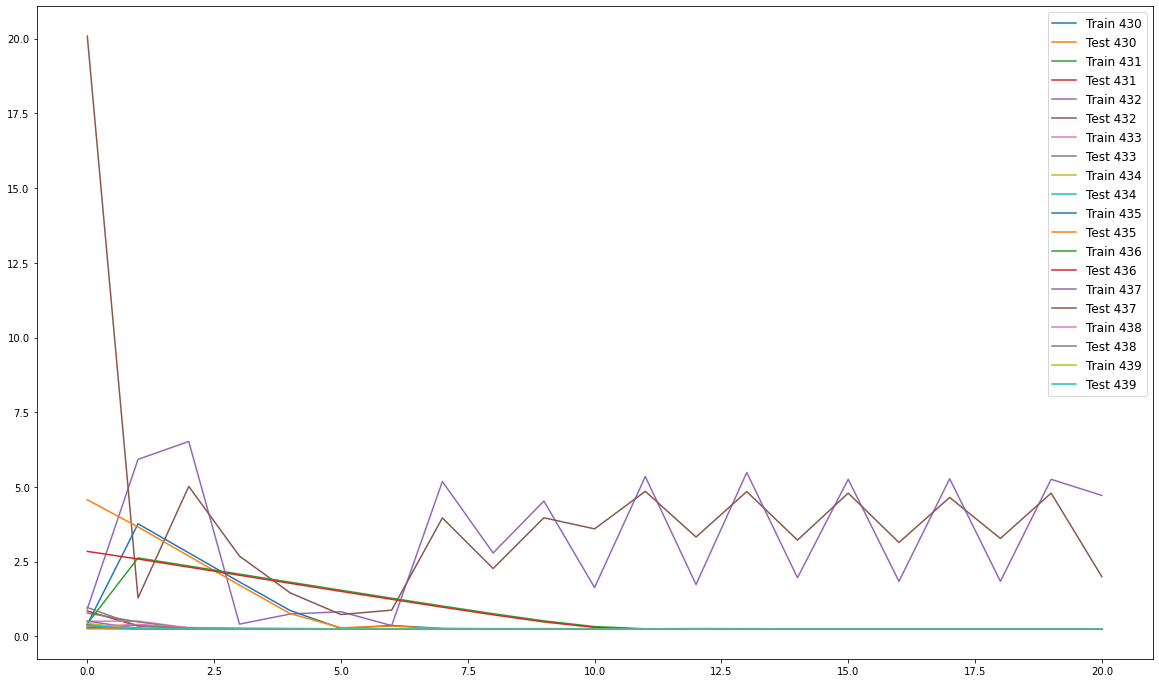

Номер сети: 440
Номер сети: 441
Номер сети: 442
Номер сети: 443
Номер сети: 444
Номер сети: 445
Номер сети: 446
Номер сети: 447
Номер сети: 448
Номер сети: 449


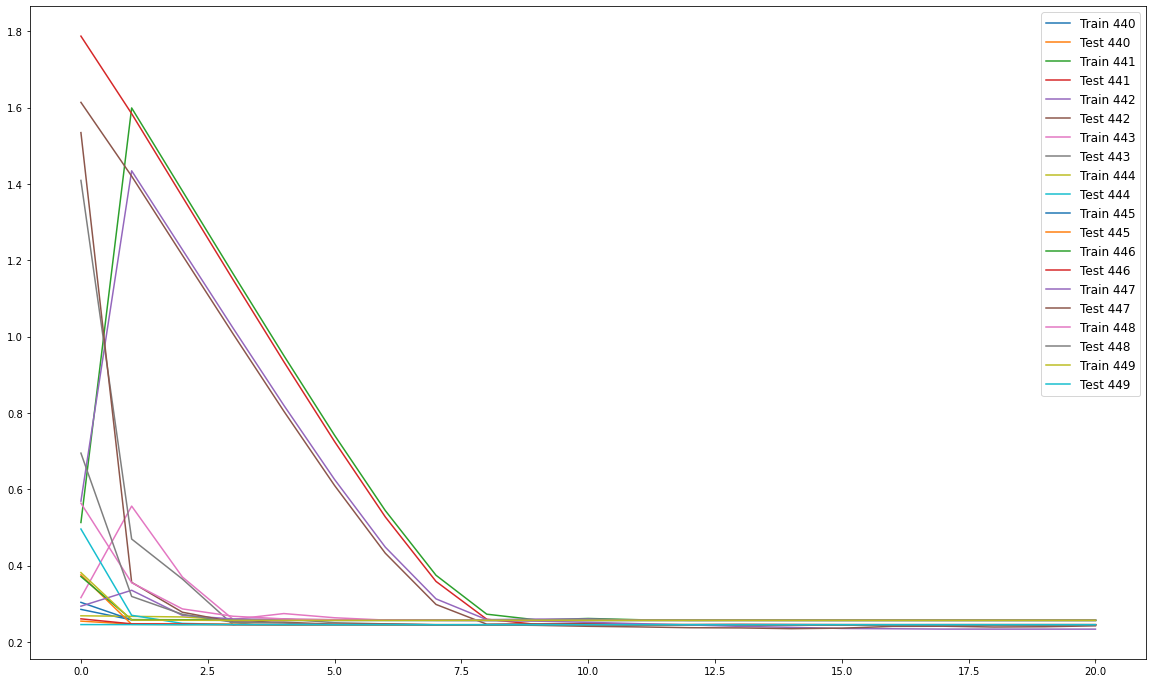

Номер сети: 450
Номер сети: 451
Номер сети: 452
Номер сети: 453
Номер сети: 454
Номер сети: 455
Номер сети: 456
Номер сети: 457
Номер сети: 458
Номер сети: 459


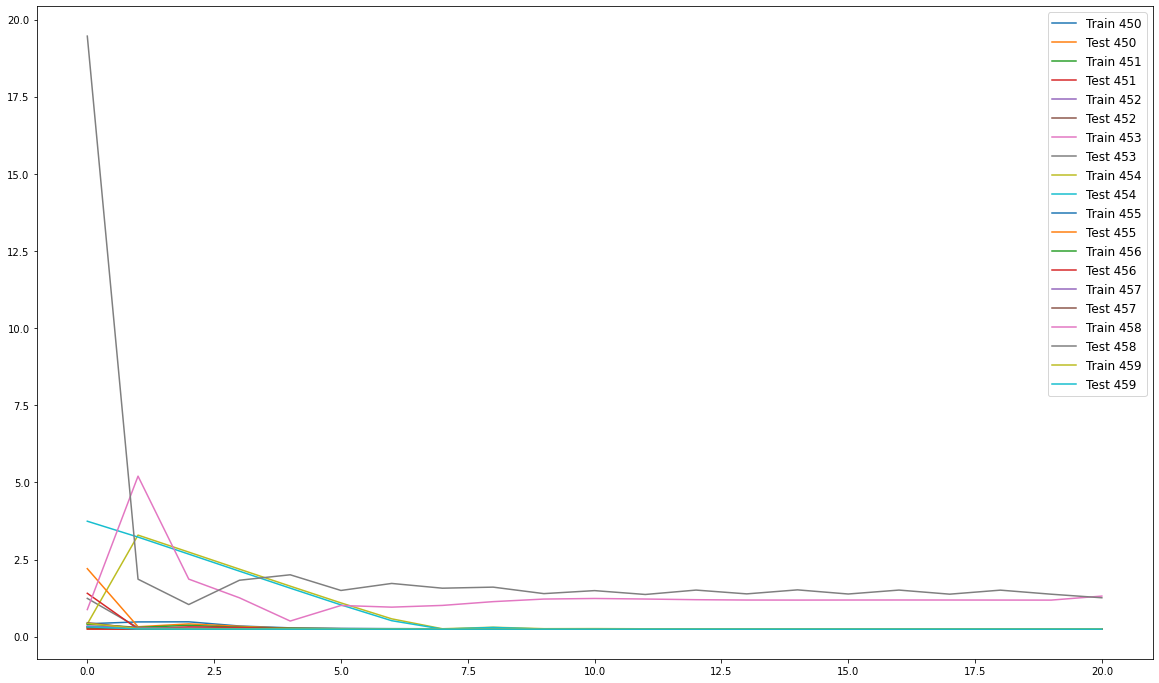

Номер сети: 460
Номер сети: 461
Номер сети: 462
Номер сети: 463
Номер сети: 464
Номер сети: 465
Номер сети: 466
Номер сети: 467
Номер сети: 468
Номер сети: 469


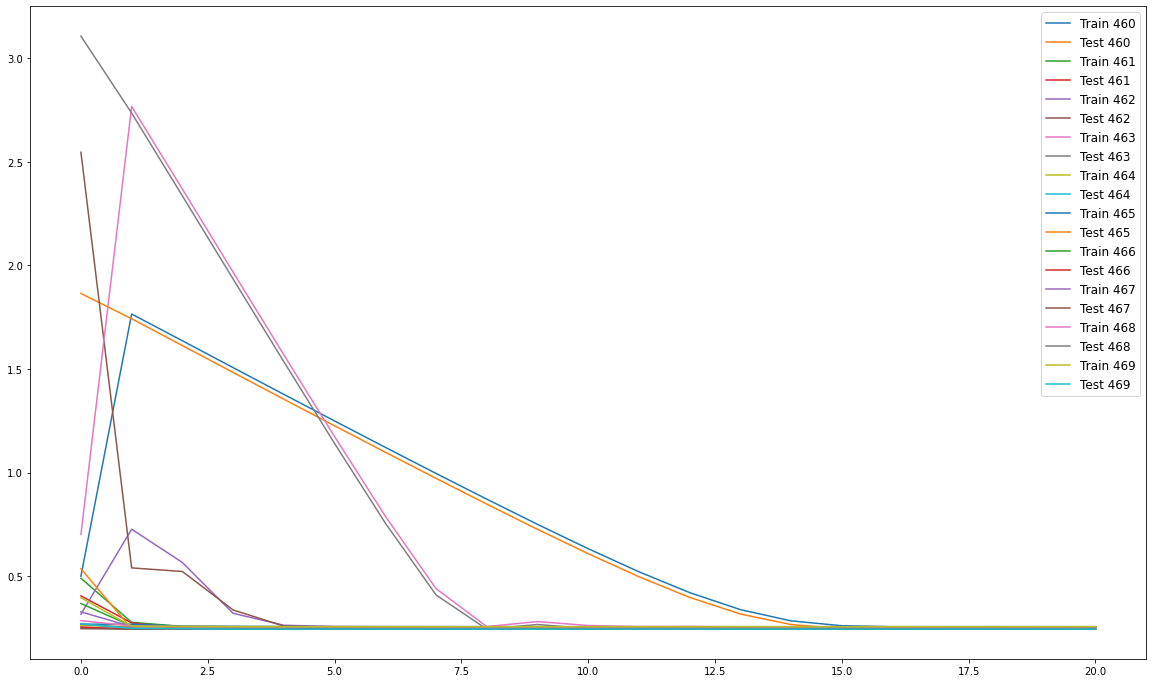

Номер сети: 470
Номер сети: 471
Номер сети: 472
Номер сети: 473
Номер сети: 474
Номер сети: 475
Номер сети: 476
Номер сети: 477
Номер сети: 478
Номер сети: 479


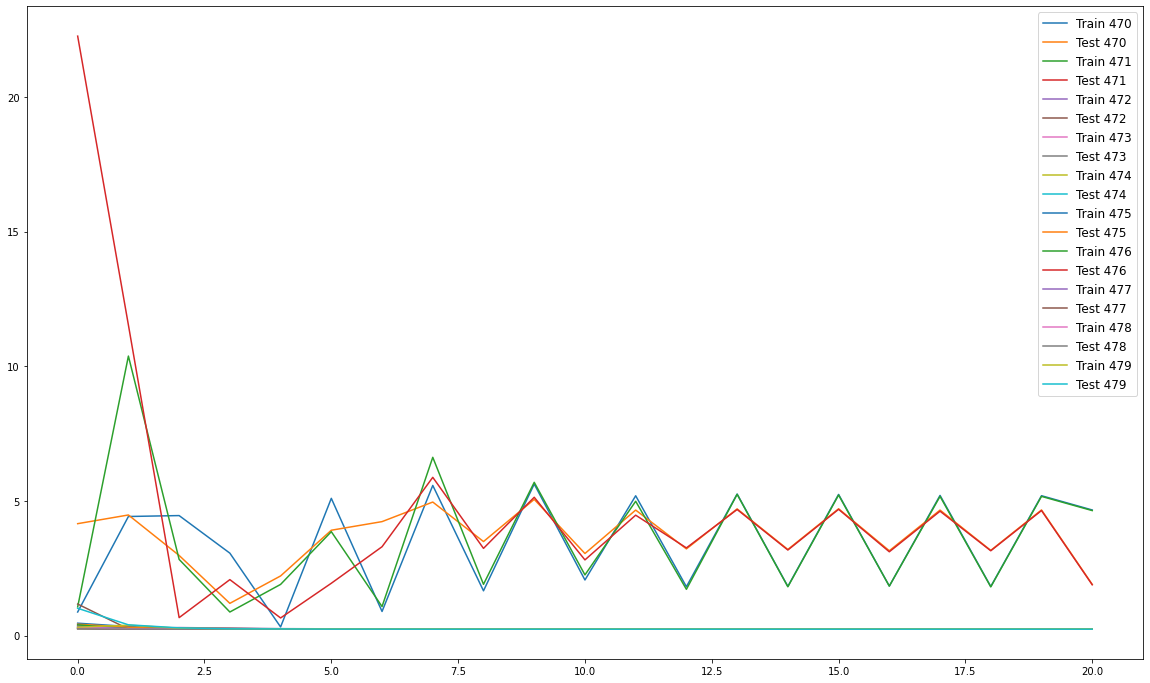

Номер сети: 480
Номер сети: 481
Номер сети: 482
Номер сети: 483
Номер сети: 484
Номер сети: 485
Номер сети: 486
Номер сети: 487
Номер сети: 488
Номер сети: 489


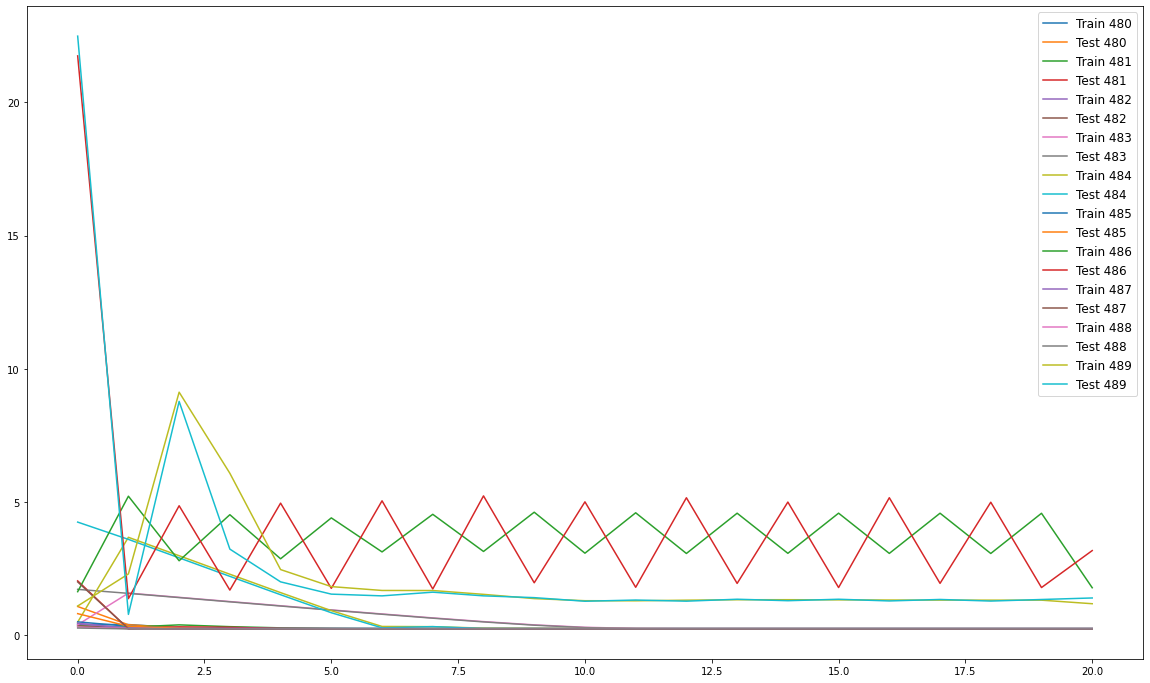

Номер сети: 490
Номер сети: 491
Номер сети: 492
Номер сети: 493
Номер сети: 494
Номер сети: 495
Номер сети: 496
Номер сети: 497
Номер сети: 498
Номер сети: 499


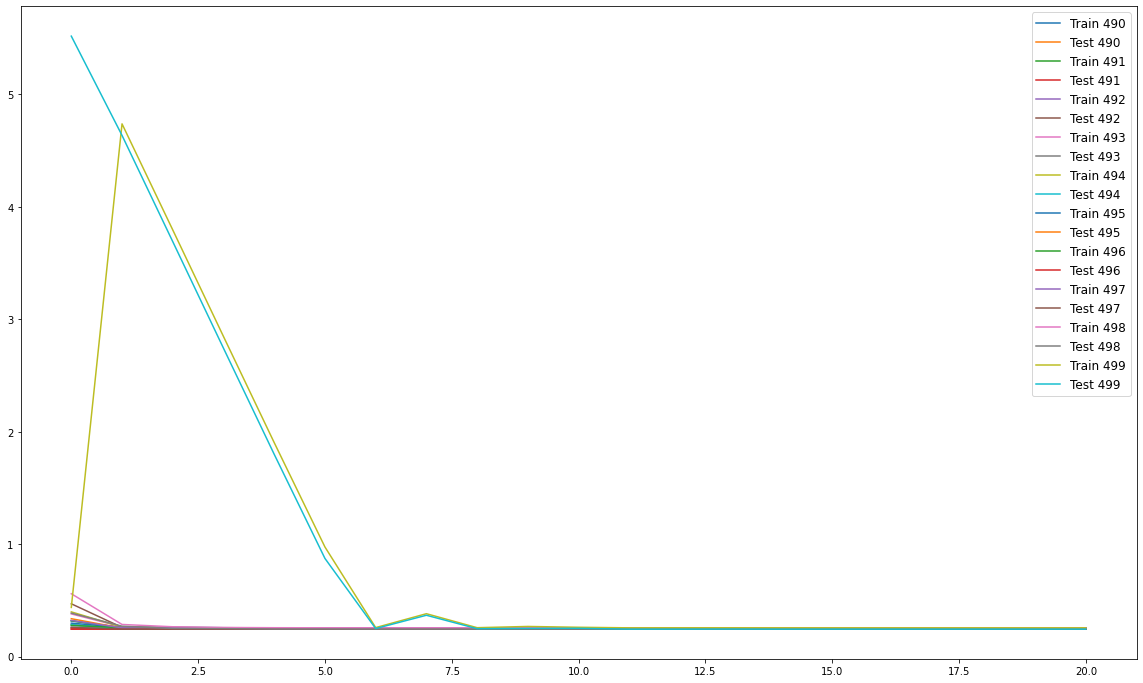

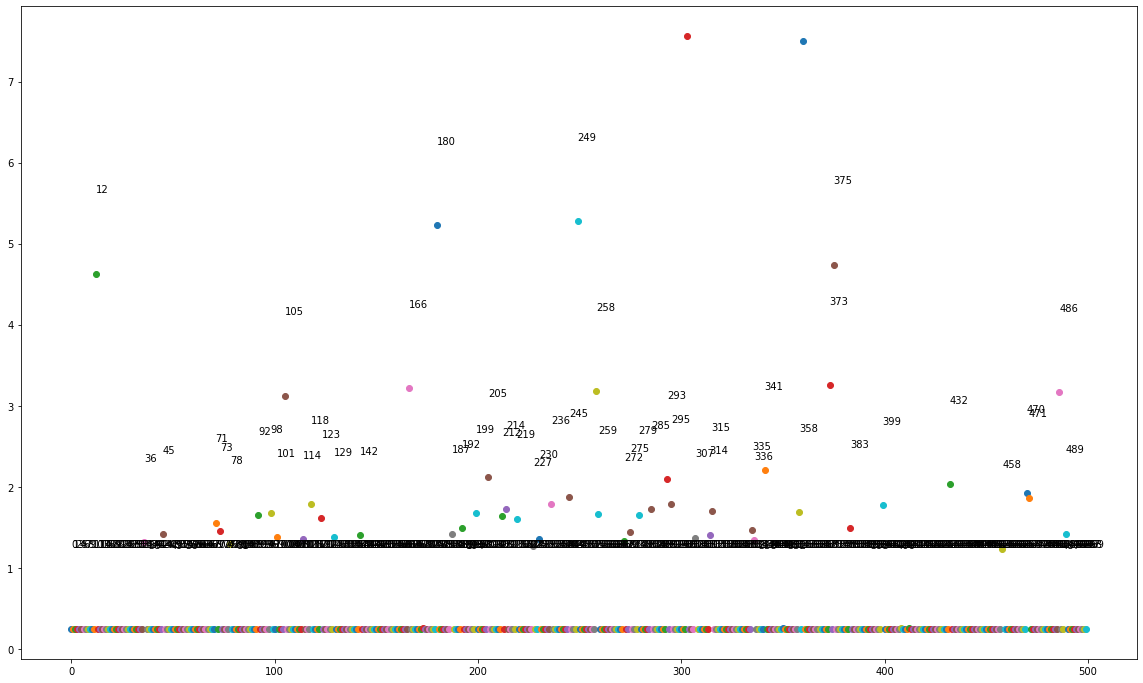

In [101]:
conf = []
for g in range(500):
    print(f'Номер сети: {g}')
    l = np.random.randint(0,8)
    n_neurons = [train_features.shape[1]]
    net_layers1 = []
    for j in range(l):
        n_neurons.append(np.random.randint(2,100))
    n_neurons.append(1)

    for i in range(1, len(n_neurons) - 1):
            net_layers1.append(nn.Linear(n_neurons[i-1],n_neurons[i])) 
            if (i+1) % 2 == 0:
                    net_layers1.append(nn.Tanh()) 
    net_layers1.append(nn.Linear(n_neurons[-2], n_neurons[-1]))
    net1 = nn.Sequential(*net_layers1)
    L1_train = []
    L1_test = []
    optimizer = torch.optim.Adam(net1.parameters(),lr=1e-3)
    conf.append([g,n_neurons])
    loss = nn.MSELoss()

    num_epochs = 200
    for epoch in range(num_epochs):
        net1.train()
        optimizer.zero_grad()
        
        preds = net1.forward(train_features).flatten()
        loss_value = torch.sqrt(loss(preds, train_ans))
        loss_value.backward()
        
        optimizer.step()
        
        if epoch % 10 == 0 or epoch == num_epochs-1:
            L1_train.append(loss_value.detach().numpy())
            net1.eval()
            vall_pred = net1.forward(vall_features).flatten()
            L1 = torch.sqrt(loss(vall_pred,vall_ans))
            L1_test.append(L1.detach().numpy())
    rmse = mse(test_ans.detach(), net1.forward(test_features).flatten().detach(), squared=False)
    conf[g].append(rmse)
    x = np.array(range(0, len(L1_train)))
    if (g + 1) % 10 == 1:
         plt.figure(figsize=(20,12))
    plt.plot(x,L1_train,label=f'Train {g}')
    plt.plot(x,L1_test,label=f'Test {g}')
    plt.legend(loc='best', fontsize=12)
    if (g + 1) % 10 == 0:
         plt.show()
plt.figure(figsize=(20,12))
for i in range(len(conf)):
     plt.scatter(i,conf[i][2])
     plt.annotate(f"{i}", xy=[i,conf[i][2]+1])

In [102]:
nets = pd.DataFrame(conf)

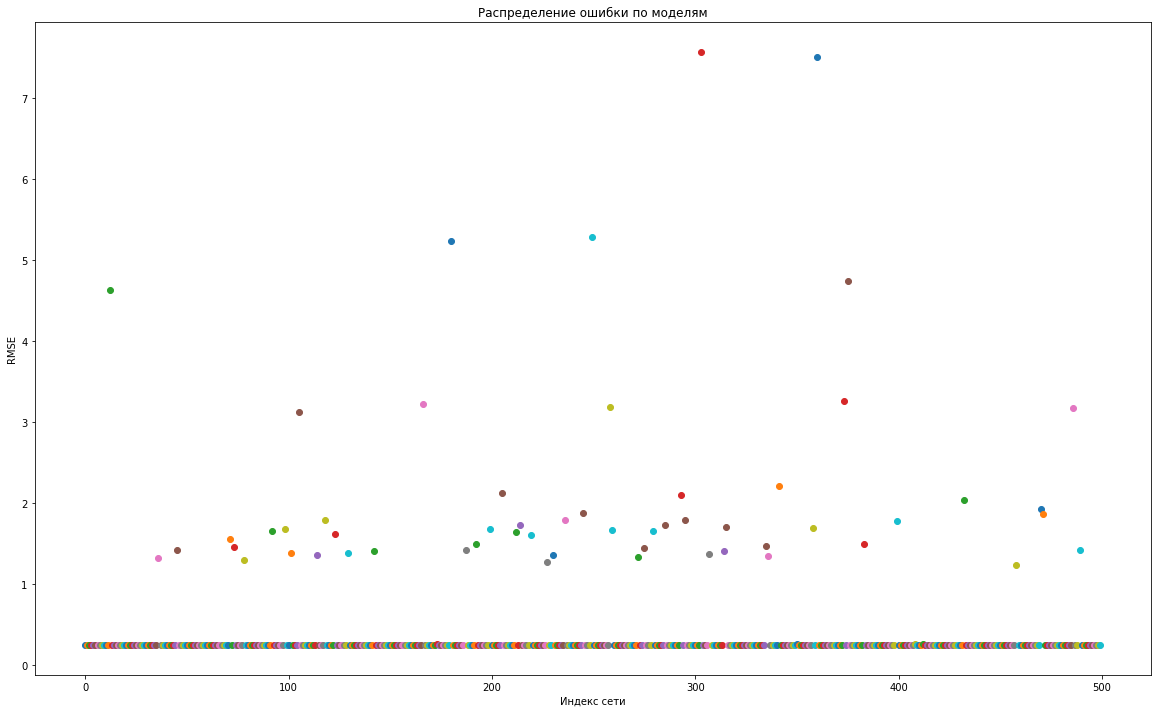

In [103]:
plt.figure(figsize=(20,12))
plt.title('Распределение ошибки по моделям')
plt.xlabel('Индекс сети')
plt.ylabel('RMSE')
for i in range(len(conf)):
    plt.scatter(i,conf[i][2])
plt.show()

In [112]:
nets.sort_values(by = [2]).head(20)

0                                       1         2
38    38                          [26066, 97, 1]  0.242999
49    49                      [26066, 38, 38, 1]  0.243187
338  338                          [26066, 36, 1]  0.243884
406  406                      [26066, 79, 50, 1]  0.245335
81    81                  [26066, 14, 67, 59, 1]  0.245621
393  393           [26066, 30, 33, 31, 3, 59, 1]  0.246156
56    56                  [26066, 21, 73, 15, 1]  0.246202
352  352                          [26066, 78, 1]  0.246693
487  487                          [26066, 34, 1]  0.246840
194  194  [26066, 76, 65, 82, 72, 66, 32, 60, 1]  0.246873
133  133                          [26066, 51, 1]  0.247554
316  316                  [26066, 72, 78, 89, 1]  0.247807
10    10                           [26066, 2, 1]  0.248096
174  174      [26066, 98, 20, 68, 58, 29, 22, 1]  0.248107
26    26          [26066, 32, 81, 66, 18, 70, 1]  0.248115
465  465              [26066, 20, 49, 60, 89, 1]  0.248122
186  186                          [26066, 17, 1]  0.248127
21    21          [26066, 96, 29, 22, 23, 46, 1]  0.248132
361  361                          [26066, 17, 1]  0.248135
2      2                          [26066, 46, 1]  0.248135

После прогонки 500 нейронок, видим что самое лучшее значение это 0.24, ок можно еще немного поэкспеементировать.

Номер сети: 0
Номер эпохт: 0
Номер эпохт: 10
Номер эпохт: 20
Номер эпохт: 30
Номер эпохт: 40
Номер эпохт: 50
Номер эпохт: 60
Номер эпохт: 70
Номер эпохт: 80
Номер эпохт: 90
Номер сети: 1
Номер эпохт: 0
Номер эпохт: 10
Номер эпохт: 20
Номер эпохт: 30
Номер эпохт: 40
Номер эпохт: 50
Номер эпохт: 60
Номер эпохт: 70
Номер эпохт: 80
Номер эпохт: 90
Номер сети: 2
Номер эпохт: 0
Номер эпохт: 10
Номер эпохт: 20
Номер эпохт: 30
Номер эпохт: 40
Номер эпохт: 50
Номер эпохт: 60
Номер эпохт: 70
Номер эпохт: 80
Номер эпохт: 90
Номер сети: 3
Номер эпохт: 0
Номер эпохт: 10
Номер эпохт: 20
Номер эпохт: 30
Номер эпохт: 40
Номер эпохт: 50
Номер эпохт: 60
Номер эпохт: 70
Номер эпохт: 80
Номер эпохт: 90
Номер сети: 4
Номер эпохт: 0
Номер эпохт: 10
Номер эпохт: 20
Номер эпохт: 30
Номер эпохт: 40
Номер эпохт: 50
Номер эпохт: 60
Номер эпохт: 70
Номер эпохт: 80
Номер эпохт: 90
Номер сети: 5
Номер эпохт: 0
Номер эпохт: 10
Номер эпохт: 20
Номер эпохт: 30
Номер эпохт: 40
Номер эпохт: 50
Номер эпохт: 60
Номер эпох

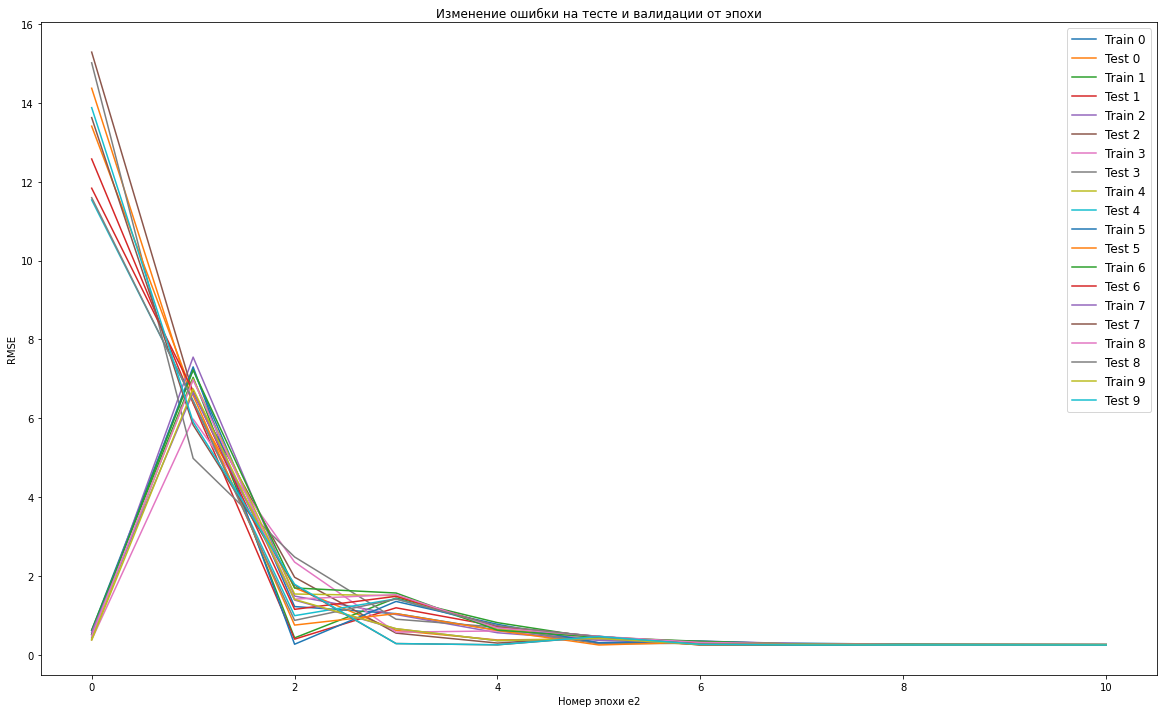

Номер сети: 10
Номер эпохт: 0
Номер эпохт: 10
Номер эпохт: 20
Номер эпохт: 30
Номер эпохт: 40
Номер эпохт: 50
Номер эпохт: 60
Номер эпохт: 70
Номер эпохт: 80
Номер эпохт: 90
Номер сети: 11
Номер эпохт: 0
Номер эпохт: 10
Номер эпохт: 20
Номер эпохт: 30
Номер эпохт: 40
Номер эпохт: 50
Номер эпохт: 60
Номер эпохт: 70
Номер эпохт: 80
Номер эпохт: 90
Номер сети: 12
Номер эпохт: 0
Номер эпохт: 10
Номер эпохт: 20
Номер эпохт: 30
Номер эпохт: 40
Номер эпохт: 50
Номер эпохт: 60
Номер эпохт: 70
Номер эпохт: 80
Номер эпохт: 90
Номер сети: 13
Номер эпохт: 0
Номер эпохт: 10
Номер эпохт: 20
Номер эпохт: 30
Номер эпохт: 40
Номер эпохт: 50
Номер эпохт: 60
Номер эпохт: 70
Номер эпохт: 80
Номер эпохт: 90
Номер сети: 14
Номер эпохт: 0
Номер эпохт: 10
Номер эпохт: 20
Номер эпохт: 30
Номер эпохт: 40
Номер эпохт: 50
Номер эпохт: 60
Номер эпохт: 70
Номер эпохт: 80
Номер эпохт: 90
Номер сети: 15
Номер эпохт: 0
Номер эпохт: 10
Номер эпохт: 20
Номер эпохт: 30
Номер эпохт: 40
Номер эпохт: 50
Номер эпохт: 60
Номе

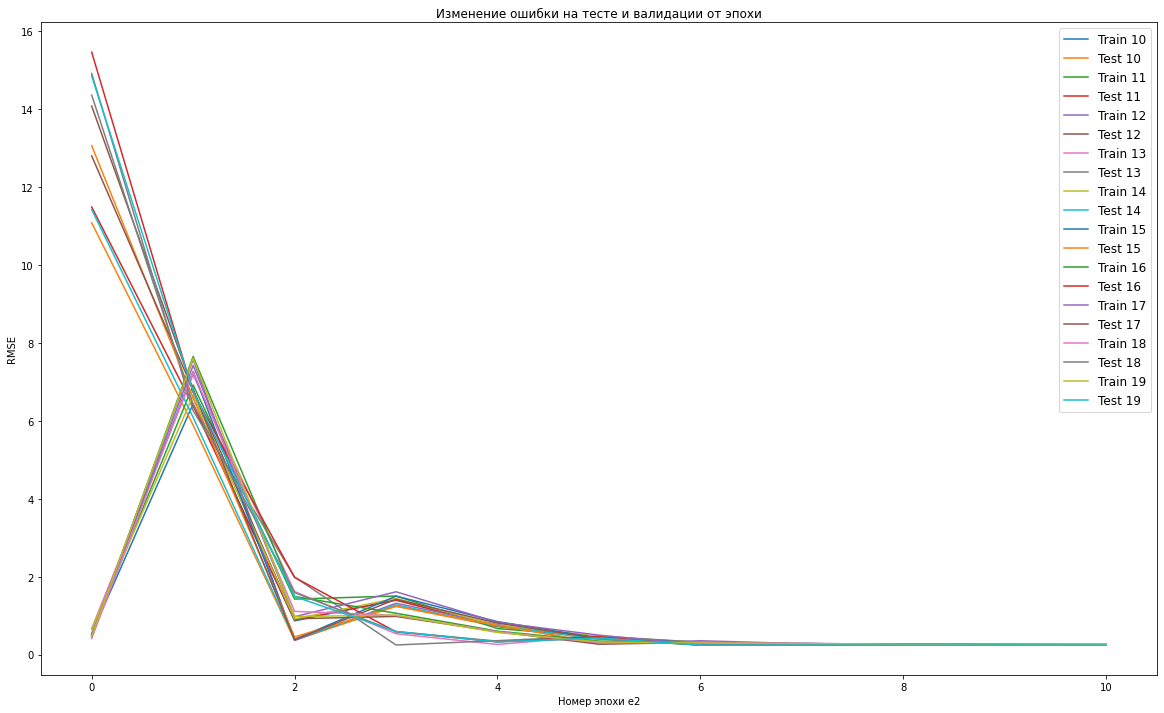

Номер сети: 20
Номер эпохт: 0
Номер эпохт: 10
Номер эпохт: 20
Номер эпохт: 30
Номер эпохт: 40
Номер эпохт: 50
Номер эпохт: 60
Номер эпохт: 70
Номер эпохт: 80
Номер эпохт: 90
Номер сети: 21
Номер эпохт: 0
Номер эпохт: 10
Номер эпохт: 20
Номер эпохт: 30
Номер эпохт: 40
Номер эпохт: 50
Номер эпохт: 60
Номер эпохт: 70
Номер эпохт: 80
Номер эпохт: 90
Номер сети: 22
Номер эпохт: 0
Номер эпохт: 10
Номер эпохт: 20
Номер эпохт: 30
Номер эпохт: 40
Номер эпохт: 50
Номер эпохт: 60
Номер эпохт: 70
Номер эпохт: 80
Номер эпохт: 90
Номер сети: 23
Номер эпохт: 0
Номер эпохт: 10
Номер эпохт: 20
Номер эпохт: 30
Номер эпохт: 40
Номер эпохт: 50
Номер эпохт: 60
Номер эпохт: 70
Номер эпохт: 80
Номер эпохт: 90
Номер сети: 24
Номер эпохт: 0
Номер эпохт: 10
Номер эпохт: 20
Номер эпохт: 30
Номер эпохт: 40
Номер эпохт: 50
Номер эпохт: 60
Номер эпохт: 70
Номер эпохт: 80
Номер эпохт: 90
Номер сети: 25
Номер эпохт: 0
Номер эпохт: 10
Номер эпохт: 20
Номер эпохт: 30
Номер эпохт: 40
Номер эпохт: 50
Номер эпохт: 60
Номе

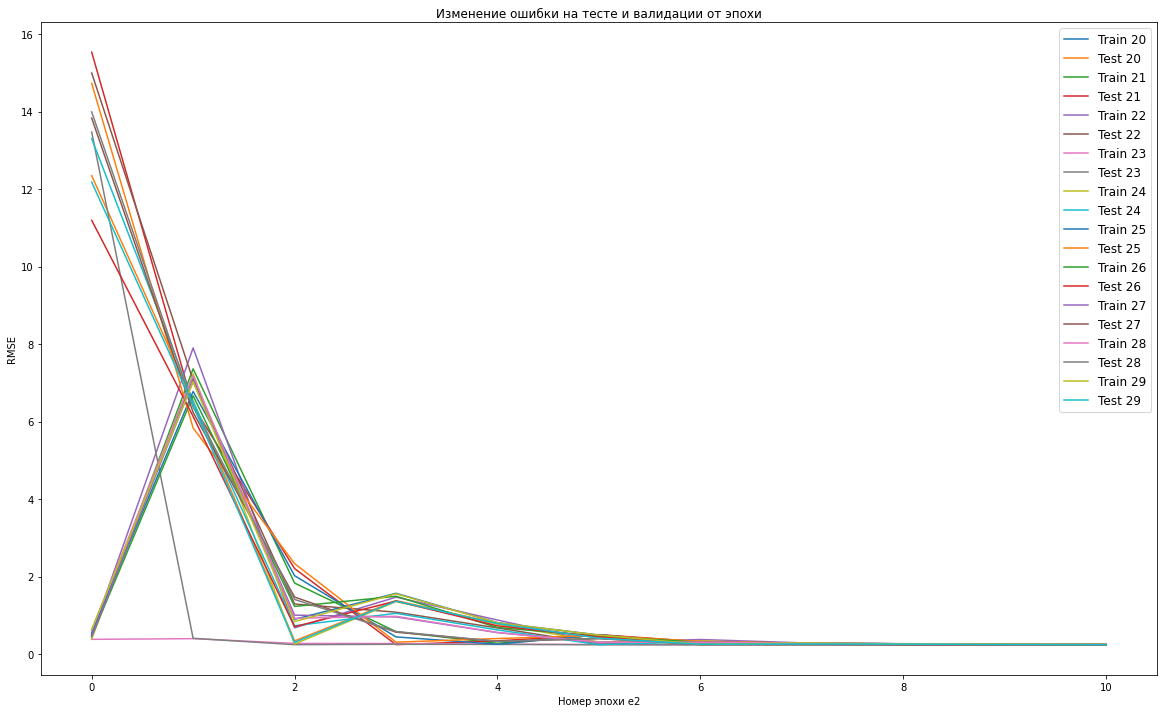

Номер сети: 30
Номер эпохт: 0
Номер эпохт: 10
Номер эпохт: 20
Номер эпохт: 30
Номер эпохт: 40
Номер эпохт: 50
Номер эпохт: 60
Номер эпохт: 70
Номер эпохт: 80
Номер эпохт: 90
Номер сети: 31
Номер эпохт: 0
Номер эпохт: 10
Номер эпохт: 20
Номер эпохт: 30
Номер эпохт: 40
Номер эпохт: 50
Номер эпохт: 60
Номер эпохт: 70
Номер эпохт: 80
Номер эпохт: 90
Номер сети: 32
Номер эпохт: 0
Номер эпохт: 10
Номер эпохт: 20
Номер эпохт: 30
Номер эпохт: 40
Номер эпохт: 50
Номер эпохт: 60
Номер эпохт: 70
Номер эпохт: 80
Номер эпохт: 90
Номер сети: 33
Номер эпохт: 0
Номер эпохт: 10
Номер эпохт: 20
Номер эпохт: 30
Номер эпохт: 40
Номер эпохт: 50
Номер эпохт: 60
Номер эпохт: 70
Номер эпохт: 80
Номер эпохт: 90
Номер сети: 34
Номер эпохт: 0
Номер эпохт: 10
Номер эпохт: 20
Номер эпохт: 30
Номер эпохт: 40
Номер эпохт: 50
Номер эпохт: 60
Номер эпохт: 70
Номер эпохт: 80
Номер эпохт: 90
Номер сети: 35
Номер эпохт: 0
Номер эпохт: 10
Номер эпохт: 20
Номер эпохт: 30
Номер эпохт: 40
Номер эпохт: 50
Номер эпохт: 60
Номе

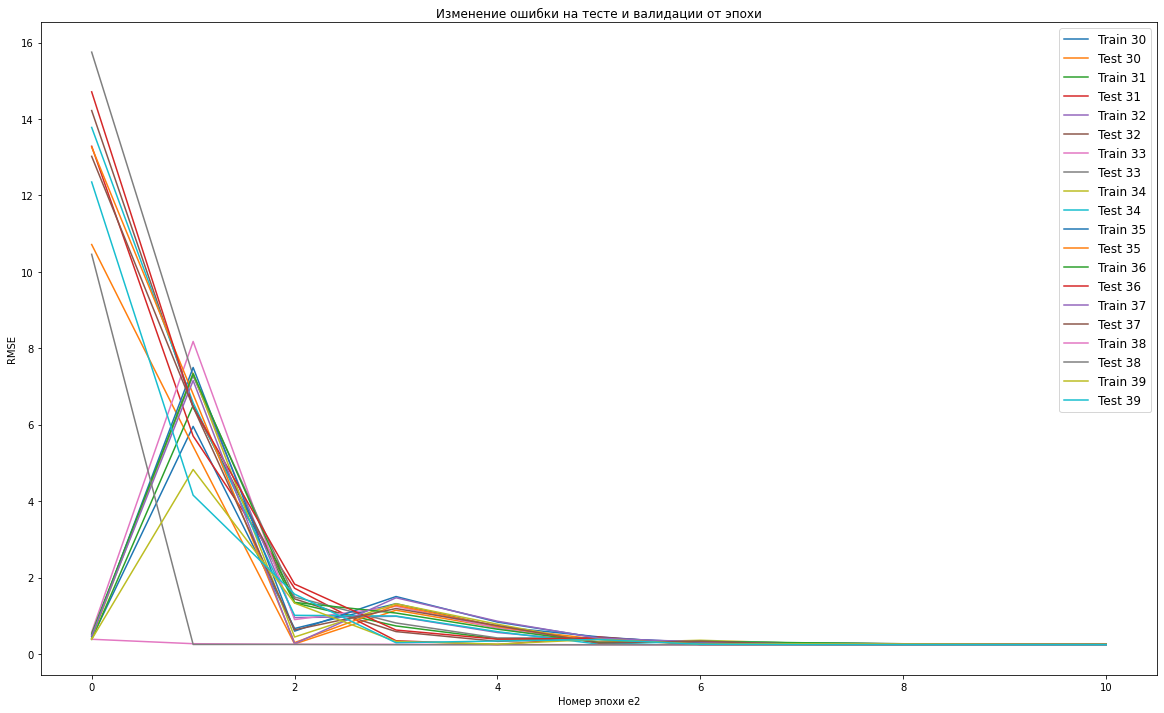

Номер сети: 40
Номер эпохт: 0
Номер эпохт: 10
Номер эпохт: 20
Номер эпохт: 30
Номер эпохт: 40
Номер эпохт: 50
Номер эпохт: 60
Номер эпохт: 70
Номер эпохт: 80
Номер эпохт: 90
Номер сети: 41
Номер эпохт: 0
Номер эпохт: 10
Номер эпохт: 20
Номер эпохт: 30
Номер эпохт: 40
Номер эпохт: 50
Номер эпохт: 60
Номер эпохт: 70
Номер эпохт: 80
Номер эпохт: 90
Номер сети: 42
Номер эпохт: 0
Номер эпохт: 10
Номер эпохт: 20
Номер эпохт: 30
Номер эпохт: 40
Номер эпохт: 50
Номер эпохт: 60
Номер эпохт: 70
Номер эпохт: 80
Номер эпохт: 90
Номер сети: 43
Номер эпохт: 0
Номер эпохт: 10
Номер эпохт: 20
Номер эпохт: 30
Номер эпохт: 40
Номер эпохт: 50
Номер эпохт: 60
Номер эпохт: 70
Номер эпохт: 80
Номер эпохт: 90
Номер сети: 44
Номер эпохт: 0
Номер эпохт: 10
Номер эпохт: 20
Номер эпохт: 30
Номер эпохт: 40
Номер эпохт: 50
Номер эпохт: 60
Номер эпохт: 70
Номер эпохт: 80
Номер эпохт: 90
Номер сети: 45
Номер эпохт: 0
Номер эпохт: 10
Номер эпохт: 20
Номер эпохт: 30
Номер эпохт: 40
Номер эпохт: 50
Номер эпохт: 60
Номе

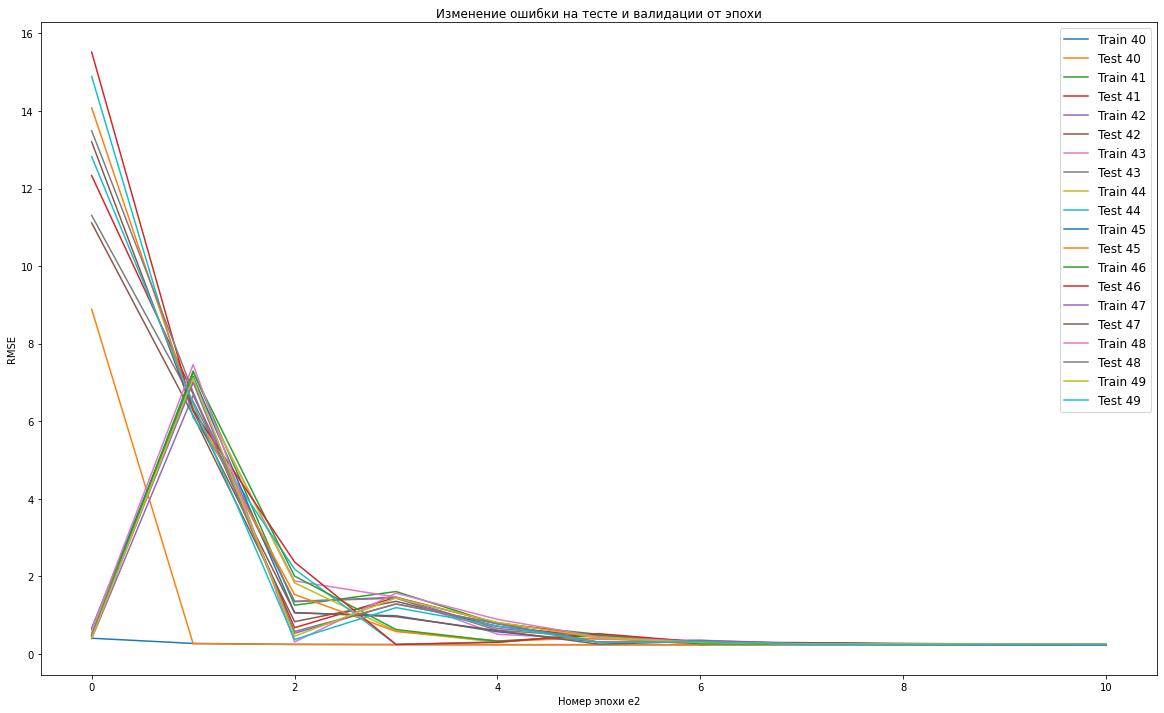

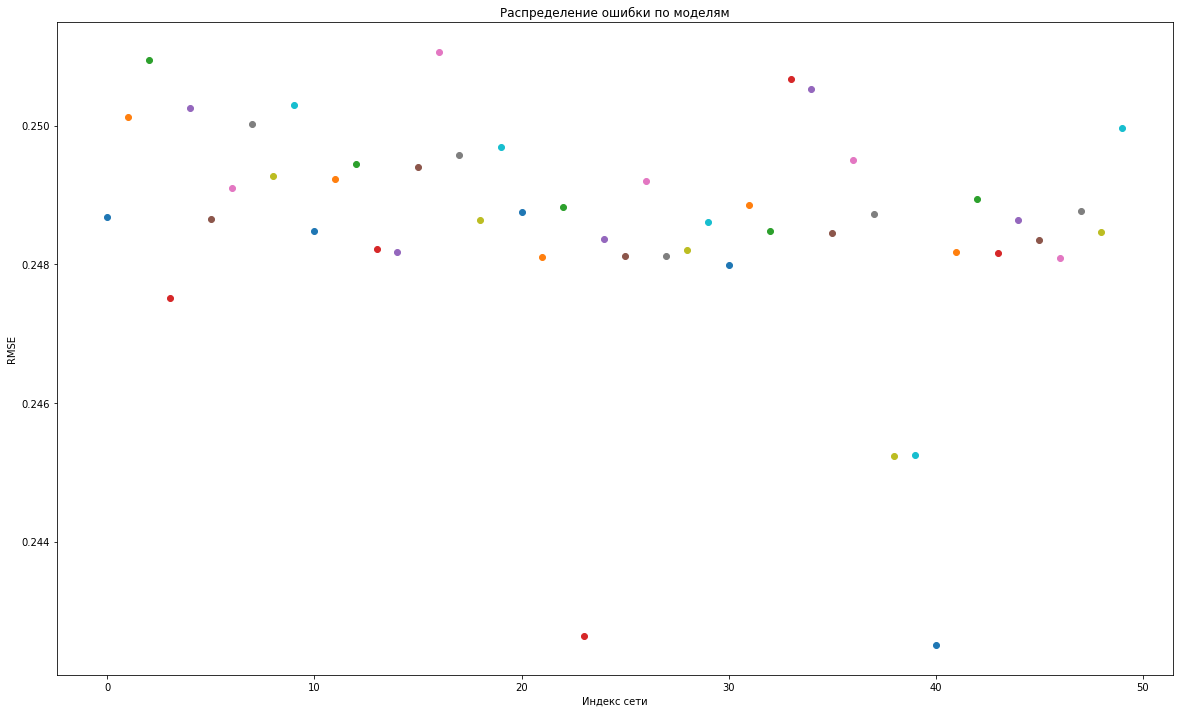

In [115]:
conf = []
for g in range(50):
    print(f'Номер сети: {g}')
    l = 1
    n_neurons = [train_features.shape[1]]
    net_layers1 = []
    for j in range(l):
        n_neurons.append(np.random.randint(500,1000))
    n_neurons.append(1)

    for i in range(1, len(n_neurons) - 1):
            net_layers1.append(nn.Linear(n_neurons[i-1],n_neurons[i])) 
            if (i+1) % 2 == 0:
                    net_layers1.append(nn.Tanh()) 
    net_layers1.append(nn.Linear(n_neurons[-2], n_neurons[-1]))
    net1 = nn.Sequential(*net_layers1)
    L1_train = []
    L1_test = []
    optimizer = torch.optim.Adam(net1.parameters(),lr=1e-3)
    conf.append([g,n_neurons])
    loss = nn.MSELoss()

    num_epochs = 100
    for epoch in range(num_epochs):
        if epoch % 10 == 0: print(f'Номер эпохт: {epoch}')
        net1.train()
        optimizer.zero_grad()
        
        preds = net1.forward(train_features).flatten()
        loss_value = torch.sqrt(loss(preds, train_ans))
        loss_value.backward()
        
        optimizer.step()
        
        if epoch % 10 == 0 or epoch == num_epochs-1:
            L1_train.append(loss_value.detach().numpy())
            net1.eval()
            vall_pred = net1.forward(vall_features).flatten()
            L1 = torch.sqrt(loss(vall_pred,vall_ans))
            L1_test.append(L1.detach().numpy())
    rmse = mse(test_ans.detach(), net1.forward(test_features).flatten().detach(), squared=False)
    conf[g].append(rmse)
    conf[g].append(net1)
    x = np.array(range(0, len(L1_train)))
    if (g + 1) % 10 == 1:
        plt.figure(figsize=(20,12))
        plt.title('Изменение ошибки на тесте и валидации от эпохи')
        plt.xlabel('Номер эпохи е2')
        plt.ylabel('RMSE')
    plt.plot(x,L1_train,label=f'Train {g}')
    plt.plot(x,L1_test,label=f'Test {g}')
    plt.legend(loc='best', fontsize=12)
    if (g + 1) % 10 == 0:
         plt.show()
plt.figure(figsize=(20,12))
plt.title('Распределение ошибки по моделям')
plt.xlabel('Индекс сети')
plt.ylabel('RMSE')
for i in range(len(conf)):
     plt.scatter(i,conf[i][2])
     plt.annotate(f"{i}", xy=[i,conf[i][2]+1])
plt.show()

In [117]:
nets = pd.DataFrame(conf)

In [260]:
nets.sort_values(by = [2]).head(20)

0                1         2  \
40  40  [26066, 570, 1]  0.242507   
23  23  [26066, 958, 1]  0.242633   
38  38  [26066, 880, 1]  0.245237   
39  39  [26066, 661, 1]  0.245251   
3    3  [26066, 999, 1]  0.247508   
30  30  [26066, 533, 1]  0.247984   
46  46  [26066, 991, 1]  0.248093   
21  21  [26066, 978, 1]  0.248110   
25  25  [26066, 956, 1]  0.248122   
27  27  [26066, 815, 1]  0.248122   
43  43  [26066, 513, 1]  0.248163   
41  41  [26066, 603, 1]  0.248180   
14  14  [26066, 575, 1]  0.248183   
28  28  [26066, 820, 1]  0.248204   
13  13  [26066, 933, 1]  0.248220   
45  45  [26066, 834, 1]  0.248347   
24  24  [26066, 725, 1]  0.248359   
35  35  [26066, 692, 1]  0.248446   
48  48  [26066, 726, 1]  0.248460   
32  32  [26066, 833, 1]  0.248476   

                                                    3  
40  [Linear(in_features=26066, out_features=570, b...  
23  [Linear(in_features=26066, out_features=958, b...  
38  [Linear(in_features=26066, out_features=880, b...  
39  [Linear(in_features=26066, out_features=661, b...  
3   [Linear(in_features=26066, out_features=999, b...  
30  [Linear(in_features=26066, out_features=533, b...  
46  [Linear(in_features=26066, out_features=991, b...  
21  [Linear(in_features=26066, out_features=978, b...  
25  [Linear(in_features=26066, out_features=956, b...  
27  [Linear(in_features=26066, out_features=815, b...  
43  [Linear(in_features=26066, out_features=513, b...  
41  [Linear(in_features=26066, out_features=603, b...  
14  [Linear(in_features=26066, out_features=575, b...  
28  [Linear(in_features=26066, out_features=820, b...  
13  [Linear(in_features=26066, out_features=933, b...  
45  [Linear(in_features=26066, out_features=834, b...  
24  [Linear(in_features=26066, out_features=725, b...  
35  [Linear(in_features=26066, out_features=692, b...  
48  [Linear(in_features=26066, out_features=726, b...  
32  [Linear(in_features=26066, out_features=833, b...

Отметку в 0.24 сеть так и не пробила, занчит будем использовать катбуст.

# Функция поиска картинки

Напишем функцию которая по предсказанию модели будет выдавать самое близкое изображение к описанию.

In [336]:
def request_img(request, df, tensor):
    print('_____________________________________________________________')
    print(request)
    text = ''
    request = request.lower()
    doc = nlp(request)
    for token in doc:
        if token.is_stop: continue
        text += f'{token.lemma_} '
    flag = 1
    for word in forbidden_words:
        if word in text:
            print ("This image is unavailable in your country in compliance with local laws")
            return ()
            
    request = text
    request = re.sub(r'[.,()!?:;\-\'\"=\[\]&/\\]','',request)
    request = re.sub(r'\s',' ',request)
    df['predict'] = 0
    request = tf_idf.transform(np.array([request]))
    i = 0
    for img in tensor:
        img = img.reshape(1,len(img))
        df.loc[i, 'predict'] = model_cbr.predict(np.hstack((img,request.toarray())))
        i += 1
    plt.imshow(Image.open(f"D:/Practicum/Final_project_4/test_images/{df.sort_values(by=['predict'],ascending=False).head(1)['image'].values[0]}"))
    plt.show()

Подготовим тестовые изображения.

In [344]:
test_im = get_emb(df_test_im, 'test')

Запустим функцию

_____________________________________________________________
A black and white dog with a green collar stands in front of a sign .


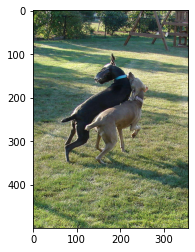

_____________________________________________________________
A person with blue hair , a baseball cap , and a hood on stands outdoors in a crowd .
This image is unavailable in your country in compliance with local laws
_____________________________________________________________
A man in a blue shirt lifts up his tennis racket and smiles .


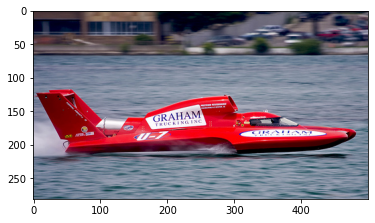

_____________________________________________________________
A little girl with purple hat is riding a tricycle along paved road by some farmland .
This image is unavailable in your country in compliance with local laws
_____________________________________________________________
A little girl with a purple fuzzy hat is riding a tricycle outside .
This image is unavailable in your country in compliance with local laws
_____________________________________________________________
Four young people with cold drinks stand on the sidewalk in front of cartoon cutouts of the Simpsons also holding cold drinks .
This image is unavailable in your country in compliance with local laws
_____________________________________________________________
A woman and a young girl riding a sled down a snowy hill while standing .
This image is unavailable in your country in compliance with local laws
_____________________________________________________________
A three legged black and white dog running b

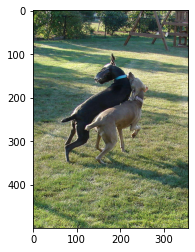

_____________________________________________________________
A snowboarder takes a ramp made of snow while others watch .


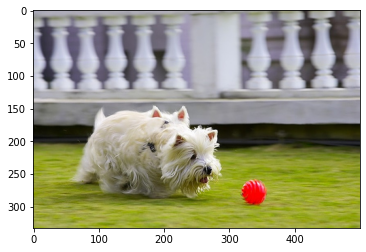

_____________________________________________________________
A young boy is holding a PlayStation controller over his head .
This image is unavailable in your country in compliance with local laws


In [337]:
for i in range(10):
    request_img(df_test_qr.sample()['query_text'].values[0],df_test_im,test_im)

# Вывод

Как видно модель с некоторыми завпросами спарвляется хорошо, а на какие-то подстроится не может. Думаю это связано с самой моделью, с этим должны хорошо справлятся нейроные сети, но сейчас нету большого временного ресурса и ресурсов принципе их обучать. В добавок могла сыграть оценка экспертов и краудсорсинга, а точнее их соотношение в финальной оценке. Также необходимо больше времени уделить на предобработку, как минимум на текст, можно использовать того же BERT для создания эмбедингов.